## RUC Fintech Hackathon (2024) 
### RUC-Tree

### 1.Import the packages

In [ ]:
import numpy as np
import pandas as pd
import re
import jieba
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from graphviz import Digraph
import matplotlib.cm as cm
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,KFold,LeaveOneOut,LeavePOut 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn import neighbors,preprocessing  
from sklearn.datasets import make_regression 
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input,Dense
import optuna
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from openfe import OpenFE, tree_to_formula, transform
from autogluon.tabular import TabularPredictor
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
from autogluon.tabular import FeatureMetadata
from transformers import BertTokenizer, BertModel
import warnings
warnings.filterwarnings(action = 'ignore')
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False
%matplotlib inline

### 2.Data Pre-processing
#### 2.1 Read the file

In [ ]:
train_data = pd.read_excel(r'C:\Users\Manager.Mo\Desktop\房价预测\raw_train_data.xlsx')
test_data = pd.read_excel(r'C:\Users\Manager.Mo\Desktop\房价预测\raw_test_data.xlsx')
detail_data = pd.read_excel(r'C:\Users\Manager.Mo\Desktop\房价预测\details.xlsx')
train_data.drop_duplicates(inplace=True)
# merge detail_data with train_data and test_data
detail_data.rename(columns = {'名称':'小区名称','区县':'区域','建筑结构':'建筑结构（小区）'},inplace = True)
train_data = pd.merge(train_data,detail_data.drop(['城市','板块','环线位置'],axis = 1),on = ['区域','小区名称'],how = 'left')
test_data = pd.merge(test_data,detail_data.drop(['城市','板块','环线位置'],axis = 1),on = ['区域','小区名称'],how = 'left')

#### 2.2 Define the extraction function

In [ ]:
def extract_numbers_inplace(series):  
    """extract the numbers in the raw data"""
    def extract_numbers(s):  
        if pd.notnull(s):  
            match = re.search(r'(-?\d+(\.\d+)?)', s)  
            if match:  
                return match.group()  
        return np.nan  
      
    return series.apply(extract_numbers)  

def extract_room_info(house_type):  
    if pd.isnull(house_type):  
        return (np.nan, np.nan, np.nan, np.nan)  
    else:  
        pattern = r'(\d+)室(\d+)厅(\d+)厨(\d+)卫'  
        match = re.match(pattern, house_type)  
        if match:  
            return match.groups()  
        else:  
            return (np.nan, np.nan, np.nan, np.nan) 
        
def extract_floor_info(floor_str):  
    if pd.isnull(floor_str):  
        return np.nan, np.nan  
    match = re.search(r'(\D+)\s*\(共(\d+)层\)', floor_str)  
    if match:  
        return match.group(1), int(match.group(2))  
    else:  
        return np.nan, np.nan  
    
# build a dictionary to convert Chinese numerals to Arabic numerals
hanzi_to_digit = {  
     '一': 1, '二': 2, '两': 2, '三': 3, '四': 4, '五': 5,  
    '六': 6, '七': 7, '八': 8, '九': 9, '十': 10, '百': 100  
}  
  
def hanzi_to_arabic(hanzi):  
    """Convert Chinese numerals to Arabic numerals."""
    result = 0  
    tmp_result = 0  
    for char in hanzi:  
        if char in hanzi_to_digit:  
            if char == '百':  
                result += tmp_result * 100  
                tmp_result = 0  
            elif char == '十':  
                if tmp_result == 0:  
                    tmp_result = 10  
                else:  
                    tmp_result *= 10  
            elif char == '零':  
                pass  
            else:  
                tmp_result += hanzi_to_digit[char]  
    result += tmp_result  
    return result  

def calculate_ratio(row):
    return row['户'] / row['梯']
def extract_fee(s):  
    if pd.isnull(s) or s == '':  
        return np.nan  
    matches = re.findall(r"\d+\.?\d*", s)  
    if len(matches) == 0:  
        return np.nan    
    elif len(matches) == 1:  
        return float(matches[0])  
    else:  
        return (float(matches[0]) + float(matches[1])) / 2  
    
def fenci(text_data):
    text_data = text_data.astype(str) 

    words_list = []

    with open(r'C:\Users\Manager.Mo\Desktop\房价预测\hit_stopwords.txt', encoding='utf-8') as f: # HIT Stopwords
        stop_words_raw = f.readlines() 
    stop_words = set(word.strip('\n') for word in stop_words_raw) 

    #jieba.load_userdict('/home/mw/project/dict_real_estate.txt') # use the Sogou and Baidu Real Estate Dictionary

    for text in text_data:
        word_generator = jieba.cut(text)
        words = [word for word in word_generator if word not in stop_words and len(word) > 1] 
        words = [word for word in words if re.match(r'[\u4e00-\u9fa5]+', word)]  # filter out non-Chinese characters
        words_list.append(words)

    return words_list    


def gen_dummies(data):
    """"Generate dummy variables for transportation, surrounding facilities, and layout features from the provided data."""
    transport_dummies_dict = {
        '是否靠近公交站':['路站','公交','公交站','公交车','公交线路','公交路线','公交车站','公交站点'],
        '是否靠近轻轨站':['轻轨','轻轨站'],
        '是否靠近火车站/高铁站':['火车站','高铁'],
        '是否靠近机场':['机场','空港']
    } 

    transport_dummies = []

    for index, words in enumerate(fenci(data['交通出行'])):
        dummy = {key: 0 for key in transport_dummies_dict}
        for key, value in transport_dummies_dict.items():
            if any(word in words for word in value):
                dummy[key] = 1
        transport_dummies.append(dummy)
  
    surrouding_dummies_dict = {
        '是否有医疗设施': ['医院', '三甲', '医疗', '诊所', '卫生院'],
        '是否有银行网点': ['银行', '农行', '支行'], 
        '是否有娱乐休闲': ['电影院', '广场', '商场', '商城', '商圈', '饭店', '湿地', '步行街', '欢乐谷', '游乐场', 'KTV', '剧院','万达'],
        '是否有教育机构（幼儿园）': ['幼儿园'],
        '是否有市场商店': ['农贸市场', '便利店', '菜市场', '商场', '商城']
    } 

    surrouding_dummies = []

    for index, words in enumerate(fenci(data['周边配套'])):
        dummy = {key: 0 for key in surrouding_dummies_dict}
        for key, value in surrouding_dummies_dict.items():
            if any(word in words for word in value):
                dummy[key] = 1
        surrouding_dummies.append(dummy)

    layout_dummies_dict = {
        '是否采光明亮':['阳面','明厨','明卫','采光','开阔','阳光','光线','敞亮','双阳','通透','明亮','朝阳'],
        '是否有落地窗':['落地窗'],
        '是否有飘窗':['飘窗'],
        '是否为洋房':['洋房'],
        '是否有储藏室':['储藏室'],
        '是否有地下室':['地下室'],
        '是否有露台':['露台'],
        '是否有小院':['小院'],
        '是否有儿童房':['儿童房'],
        '是否户型方正':['方正'],
        '是否公摊面积小':['小公摊','公摊小','无公摊','公摊面积小'],
        '是否温馨舒适':['安静','干净','舒适','隐私','私密性','温馨','方便'],
        '是否为自住房':['自住'],
        '是否物业良好':['物业'],
        '是否有天然气':['天然气'],
        '是否民水民电':['民水民电', '民水', '民电'],
        '是否临街':['临街'],
        '是否急售':['急售']
    }
    
    layout_dummies = []

    for index, words in enumerate(fenci(data['户型介绍'])):  
        dummy = {key: 0 for key in layout_dummies_dict}  
        for key, value in layout_dummies_dict.items():
            if any(word in words for word in value):
                dummy[key] = 1 
        layout_dummies.append(dummy)

    transport_dummies_df = pd.DataFrame(transport_dummies, index=data.index).fillna(0)
    surrouding_dummies_df = pd.DataFrame(surrouding_dummies, index=data.index).fillna(0)
    layout_dummies_df = pd.DataFrame(layout_dummies, index=data.index).fillna(0)

    dummies_df = pd.concat([transport_dummies_df, surrouding_dummies_df,layout_dummies_df], axis=1)

    return dummies_df

def add_na_columns(df, columns_to_check):  
    """  
    Add the corresponding "_NA" column for the specified column to indicate whether the original column is empty.
    """  
    # 遍历要检查的列名列表  
    for column in columns_to_check:  
        # 生成新的列名  
        new_column_name = f"{column}_NA"  
        # 检查原列是否为空，并生成对应的"_NA"列  
        df[new_column_name] = df[column].isnull().astype(int)  
      
    return df  

def add_subway_column(df):  
    df['地铁'] = df['房屋优势'].str.contains('地铁', case=False, na=False).astype(int)
    return df  

#### 2.3 clean the data

In [ ]:
# handle the '房屋优势' column manually
train_data['停车费用'] = train_data['停车费用'].replace('1800', '150') 
train_data['停车费用'] = train_data['停车费用'].replace('地下停车位物业收取管理费50', '50') 
train_data['停车费用'] = train_data['停车费用'].replace('1200元/年/位', '100') 
train_data['停车费用'] = train_data['停车费用'].replace('免费', '0') 
train_data['停车费用'] = train_data['停车费用'].replace('地上400-500', '450') 
train_data['停车费用'] = train_data['停车费用'].replace('租金350/月+50元管理费', '400') 
train_data['停车费用'] = train_data['停车费用'].replace('地下:400', '400') 
train_data['停车费用'] = train_data['停车费用'].replace('400-500', '450') 
train_data['停车费用'] = train_data['停车费用'].replace('90元/月/位', '90') 
train_data['停车费用'] = train_data['停车费用'].replace('100元一个月', '100') 
train_data['停车费用'] = train_data['停车费用'].replace('无固定车位不收费', '0') 
train_data['停车费用'] = train_data['停车费用'].replace('地上200', '200') 
train_data['停车费用'] = train_data['停车费用'].replace('地上100', '100') 
train_data['停车费用'] = train_data['停车费用'].replace('地下200', '200') 
train_data['停车费用'] = train_data['停车费用'].replace('地上100，地下200', '150') 
train_data['停车费用'] = train_data['停车费用'].replace('地上250，地下350', '300') 
train_data['停车费用'] = train_data['停车费用'].replace('200元/月/位', '200') 
train_data['停车费用'] = train_data['停车费用'].replace('无', '0') 
train_data['停车费用'] = train_data['停车费用'].replace('地上300；地下400', '350') 
train_data['停车费用'] = train_data['停车费用'].replace('地上350元/月/位，地下400元/月/位', '375') 
train_data['停车费用'] = train_data['停车费用'].replace('地下车库400', '400') 
train_data['停车费用'] = train_data['停车费用'].replace('地上250地下88', '169') 
train_data['停车费用'] = train_data['停车费用'].replace('地上100地下230', '165') 
train_data['停车费用'] = train_data['停车费用'].replace('暂无', '0') 
train_data['停车费用'] = train_data['停车费用'].replace('地上120地下200', '160') 
train_data['停车费用'] = train_data['停车费用'].replace('120/300', '210') 
train_data['停车费用'] = train_data['停车费用'].replace('地上:100', '100') 
train_data['停车费用'] = train_data['停车费用'].replace('600-800', '700') 
train_data['停车费用'] = train_data['停车费用'].replace('100地上', '100') 
train_data['停车费用'] = train_data['停车费用'].replace('月付180,年付150,地下260', '205') 
train_data['停车费用'] = train_data['停车费用'].replace('地上:150', '150') 
train_data['停车费用'] = train_data['停车费用'].replace('地下300', '300') 
train_data['停车费用'] = train_data['停车费用'].replace('地上免费', '0') 
train_data['停车费用'] = train_data['停车费用'].replace('80-100', '90') 
train_data['停车费用'] = train_data['停车费用'].replace('地上0元', '0') 
train_data['停车费用'] = train_data['停车费用'].replace('无停车费', '0') 
train_data['停车费用'] = train_data['停车费用'].replace('管理费120', '120') 
train_data['停车费用'] = train_data['停车费用'].replace('350-500', '425') 
train_data['停车费用'] = train_data['停车费用'].replace('地上100，地下250', '175') 
train_data['停车费用'] = train_data['停车费用'].replace('地上100地下三百', '200') 
train_data['停车费用'] = train_data['停车费用'].replace('地上1.6以下60/月，1/6到3.0是90/月，3.0以上是120/月', '90') 
train_data['停车费用'] = train_data['停车费用'].replace('地上:200', '200') 
train_data['停车费用'] = train_data['停车费用'].replace('地上10', '10') 
train_data['停车费用'] = train_data['停车费用'].replace('0n', '50') 
train_data['停车费用'] = train_data['停车费用'].replace('1200', '100') 
train_data['停车费用'] = train_data['停车费用'].replace('400~500', '450') 
train_data['停车费用'] = train_data['停车费用'].replace('500-600', '550') 
test_data['停车费用'] = test_data['停车费用'].replace('1800', '150') 
test_data['停车费用'] = test_data['停车费用'].replace('地下停车位物业收取管理费50', '50') 
test_data['停车费用'] = test_data['停车费用'].replace('1200元/年/位', '100') 
test_data['停车费用'] = test_data['停车费用'].replace('免费', '0') 
test_data['停车费用'] = test_data['停车费用'].replace('地上400-500', '450') 
test_data['停车费用'] = test_data['停车费用'].replace('租金350/月+50元管理费', '400') 
test_data['停车费用'] = test_data['停车费用'].replace('地下:400', '400') 
test_data['停车费用'] = test_data['停车费用'].replace('400-500', '450') 
test_data['停车费用'] = test_data['停车费用'].replace('90元/月/位', '90') 
test_data['停车费用'] = test_data['停车费用'].replace('100元一个月', '100') 
test_data['停车费用'] = test_data['停车费用'].replace('无固定车位不收费', '0') 
test_data['停车费用'] = test_data['停车费用'].replace('地上200', '200') 
test_data['停车费用'] = test_data['停车费用'].replace('地上100', '100') 
test_data['停车费用'] = test_data['停车费用'].replace('地下200', '200') 
test_data['停车费用'] = test_data['停车费用'].replace('地上100，地下200', '150') 
test_data['停车费用'] = test_data['停车费用'].replace('地上250，地下350', '300') 
test_data['停车费用'] = test_data['停车费用'].replace('200元/月/位', '200') 
test_data['停车费用'] = test_data['停车费用'].replace('无', '0') 
test_data['停车费用'] = test_data['停车费用'].replace('地上300；地下400', '350') 
test_data['停车费用'] = test_data['停车费用'].replace('地上350元/月/位，地下400元/月/位', '375') 
test_data['停车费用'] = test_data['停车费用'].replace('地下车库400', '400') 
test_data['停车费用'] = test_data['停车费用'].replace('地上250地下88', '169') 
test_data['停车费用'] = test_data['停车费用'].replace('地上100地下230', '165') 
test_data['停车费用'] = test_data['停车费用'].replace('暂无', '0') 
test_data['停车费用'] = test_data['停车费用'].replace('地上120地下200', '160') 
test_data['停车费用'] = test_data['停车费用'].replace('120/300', '210') 
test_data['停车费用'] = test_data['停车费用'].replace('地上:100', '100') 
test_data['停车费用'] = test_data['停车费用'].replace('600-800', '700') 
test_data['停车费用'] = test_data['停车费用'].replace('100地上', '100') 
test_data['停车费用'] = test_data['停车费用'].replace('月付180,年付150,地下260', '205') 
test_data['停车费用'] = test_data['停车费用'].replace('地上:150', '150') 
test_data['停车费用'] = test_data['停车费用'].replace('地下300', '300') 
test_data['停车费用'] = test_data['停车费用'].replace('地上免费', '0') 
test_data['停车费用'] = test_data['停车费用'].replace('80-100', '90') 
test_data['停车费用'] = test_data['停车费用'].replace('地上0元', '0') 
test_data['停车费用'] = test_data['停车费用'].replace('无停车费', '0') 
test_data['停车费用'] = test_data['停车费用'].replace('管理费120', '120') 
test_data['停车费用'] = test_data['停车费用'].replace('350-500', '425') 
test_data['停车费用'] = test_data['停车费用'].replace('地上100，地下250', '175') 
test_data['停车费用'] = test_data['停车费用'].replace('地上100地下三百', '200') 
test_data['停车费用'] = test_data['停车费用'].replace('地上1.6以下60/月，1/6到3.0是90/月，3.0以上是120/月', '90') 
test_data['停车费用'] = test_data['停车费用'].replace('地上:200', '200') 
test_data['停车费用'] = test_data['停车费用'].replace('地上10', '10') 
test_data['停车费用'] = test_data['停车费用'].replace('0n', '50') 
test_data['停车费用'] = test_data['停车费用'].replace('1200', '100') 
test_data['停车费用'] = test_data['停车费用'].replace('400~500', '450') 
test_data['停车费用'] = test_data['停车费用'].replace('500-600', '550') 

In [ ]:
keywords = ['无', '无开发商', '不知道']   
train_data['开发商'].replace(keywords, np.nan, inplace=True) 
test_data['开发商'].replace(keywords, np.nan, inplace=True) 

In [ ]:
columns_to_check = ["房屋户型", "所在楼层", "建筑面积", "套内面积", "梯户比例", "配备电梯", 
                    "上次交易", "房屋年限", "产权所属",'物业类别','开发商','物业公司','绿 化 率','容 积 率',
                   '物 业 费','建筑结构（小区）','物业办公电话','产权描述','燃气费','供热费','停车位']  
# use the functions
train_data['建筑面积'] = extract_numbers_inplace(train_data['建筑面积'])  
train_data['房屋总数'] = extract_numbers_inplace(train_data['房屋总数'])  
train_data['楼栋总数'] = extract_numbers_inplace(train_data['楼栋总数']) 
train_data['绿 化 率'] = extract_numbers_inplace(train_data['绿 化 率']) 
train_data['物 业 费'] = train_data['物 业 费'].apply(extract_fee)
train_data['燃气费'] = train_data['燃气费'].apply(extract_fee)
train_data['供热费'] = train_data['供热费'].apply(extract_fee)
train_data[['卧室', '客厅', '厨房', '卫生间']] = pd.DataFrame(train_data['房屋户型'].apply(extract_room_info).tolist(), index=train_data.index) 
floor_info = train_data['所在楼层'].apply(extract_floor_info)   
train_data['楼层位置'], train_data['总楼层数'] = zip(*floor_info)  
train_dummies = gen_dummies(train_data).astype('Int64')
train_data = add_na_columns(train_data, columns_to_check)  
train_data = add_subway_column(train_data)  

test_data['建筑面积'] = extract_numbers_inplace(test_data['建筑面积']) 
test_data['房屋总数'] = extract_numbers_inplace(test_data['房屋总数'])  
test_data['楼栋总数'] = extract_numbers_inplace(test_data['楼栋总数'])  
test_data['绿 化 率'] = extract_numbers_inplace(test_data['绿 化 率'])  
test_data['物 业 费'] = test_data['物 业 费'].apply(extract_fee)
test_data['燃气费'] = test_data['燃气费'].apply(extract_fee)
test_data['供热费'] = test_data['供热费'].apply(extract_fee)
test_data[['卧室', '客厅', '厨房', '卫生间']] = pd.DataFrame(test_data['房屋户型'].apply(extract_room_info).tolist(), index=test_data.index)
floor_info = test_data['所在楼层'].apply(extract_floor_info)  
test_data['楼层位置'], test_data['总楼层数'] = zip(*floor_info) 
test_dummies = gen_dummies(test_data).astype('Int64')
test_data = add_na_columns(test_data, columns_to_check)  
test_data = add_subway_column(test_data)  

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Manager.Mo\AppData\Local\Temp\jieba.cache
Loading model cost 1.041 seconds.
Prefix dict has been built successfully.


In [ ]:
# keep the columns same
train_unique_categories = train_data['房屋用途'].unique()  
test_unique_categories = test_data['房屋用途'].unique()  
categories_in_train_not_in_test = set(train_unique_categories) - set(test_unique_categories)   
categories_in_test_not_in_train = set(test_unique_categories) - set(train_unique_categories)  
print(f"Train独有的房屋用途类别: {categories_in_train_not_in_test}")  
print(f"Test独有的房屋用途类别: {categories_in_test_not_in_train}")

Train独有的房屋用途类别: {'车库', '工业厂房', nan, '底商'}
Test独有的房屋用途类别: set()


In [8]:
categories_to_remove = ['工业厂房', '底商', '车库']  
mask = ~train_data['房屋用途'].isin(categories_to_remove)  
train_data = train_data[mask]  

In [ ]:
# the orientation of the house
train_data['南'] = 0  
train_data['北'] = 0  
train_data['西'] = 0  
train_data['东'] = 0  
train_data['南'] = train_data['房屋朝向'].str.contains('南', case=False, na=False).astype(int)  
train_data['北'] = train_data['房屋朝向'].str.contains('北', case=False, na=False).astype(int)  
train_data['西'] = train_data['房屋朝向'].str.contains('西', case=False, na=False).astype(int)  
train_data['东'] = train_data['房屋朝向'].str.contains('东', case=False, na=False).astype(int) 

test_data['南'] = 0  
test_data['北'] = 0  
test_data['西'] = 0  
test_data['东'] = 0  
test_data['南'] = test_data['房屋朝向'].str.contains('南', case=False, na=False).astype(int)  
test_data['北'] = test_data['房屋朝向'].str.contains('北', case=False, na=False).astype(int)  
test_data['西'] = test_data['房屋朝向'].str.contains('西', case=False, na=False).astype(int)  
test_data['东'] = test_data['房屋朝向'].str.contains('东', case=False, na=False).astype(int) 

In [ ]:
# the transaction time of house
train_data['交易时间'] = pd.to_datetime(train_data['交易时间']) 
test_data['交易时间'] = pd.to_datetime(test_data['交易时间']) 
train_data['上次交易'] = pd.to_datetime(train_data['上次交易']) 
test_data['上次交易'] = pd.to_datetime(test_data['上次交易']) 

train_data['交易时间差'] = train_data.apply(
    lambda row: (row['交易时间'] - row['上次交易']).days if not pd.isna(row['上次交易']) else 0,
    axis=1)
train_data['交易时间差'] = train_data['交易时间差'].apply(lambda x: max(x, 0))
test_data['交易时间差'] = test_data.apply(
    lambda row: (row['交易时间'] - row['上次交易']).days if not pd.isna(row['上次交易']) else 0,
    axis=1)
test_data['交易时间差'] = test_data['交易时间差'].apply(lambda x: max(x, 0))

# generate year and month columns
train_data['交易年份'] = train_data['交易时间'].dt.year
train_data['交易月份'] = train_data['交易时间'].dt.month
test_data['交易年份'] = test_data['交易时间'].dt.year
test_data['交易月份'] = test_data['交易时间'].dt.month
target_date = pd.Timestamp('2016-08-31')
train_data['时间'] = (train_data['交易时间'].dt.year - target_date.year) * 12 + train_data['交易时间'].dt.month - target_date.month
test_data['时间'] = (test_data['交易时间'].dt.year - target_date.year) * 12 + test_data['交易时间'].dt.month - target_date.month

In [ ]:
# handle the '梯户比例' column
train_data[['梯', '户']] = pd.DataFrame(np.nan, index=train_data.index, columns=['梯', '户'])  
  
for index, value in train_data['梯户比例'].items():  
    if pd.notnull(value): 
        split_values = value.split('梯')  
        if len(split_values) > 1:  
            train_data.at[index, '梯'] = split_values[0]  
            train_data.at[index, '户'] = split_values[1].replace('户', '')  
        else:  
            train_data.at[index, '梯'] = split_values[0]  
    
    
test_data[['梯', '户']] = pd.DataFrame(np.nan, index=test_data.index, columns=['梯', '户'])  
for index, value in test_data['梯户比例'].items():  
    if pd.notnull(value):  
        split_values = value.split('梯')  
        if len(split_values) > 1:  
            test_data.at[index, '梯'] = split_values[0]  
            test_data.at[index, '户'] = split_values[1].replace('户', '')  
        else:  
            test_data.at[index, '梯'] = split_values[0] 

train_data['梯'] = train_data['梯'].apply(lambda x: hanzi_to_arabic(x) if pd.notnull(x) else np.nan)  
train_data['户'] = train_data['户'].apply(lambda x: hanzi_to_arabic(x) if pd.notnull(x) else np.nan)
test_data['梯'] = test_data['梯'].apply(lambda x: hanzi_to_arabic(x) if pd.notnull(x) else np.nan)  
test_data['户'] = test_data['户'].apply(lambda x: hanzi_to_arabic(x) if pd.notnull(x) else np.nan)

In [ ]:
# deal with the outliers in '建筑面积' column
train_data['建筑面积'] = train_data['建筑面积'].astype(float)  
test_data['建筑面积'] = test_data['建筑面积'].astype(float)  
replacements = {  
    1260: 126,  
    8264: 82.64,  
    1151: 115.1,  
    9152: 91.52  
}  
train_data['建筑面积'] = train_data['建筑面积'].replace(replacements)  

replacements = {  
    9742: 97.42,  
    1188.11: 118.811,  
    1081.2: 108.12
}    
test_data['建筑面积'] = test_data['建筑面积'].replace(replacements)  

#### 2.4 Feature Engineering
##### To fill in the null values here, I used three methods: 1. Manual strategic filling (filling in the median of adjacent locations) 2. Without filling, directly run with XGBoost. 3. Use KNN interpolation for filling. Later, I will compare the effects of these three methods.
##### Based on the original variables, I generated some key variables that I consider, such as logarithmic step-to-household ratio, distance from the center point, etc. Furthermore, I introduced macroeconomic variables; Finally, I called a package OpenFE that can generate Deep features.

#### 2.4.1 Use macroeconomic index

In [ ]:
# read the data
time_data = pd.read_excel(r"C:\Users\Manager.Mo\Desktop\real_estate_climate_index.xlsx")
time_data['交易时间'] = pd.to_datetime(time_data['交易时间'])
time_data['交易年份'] = time_data['交易时间'].dt.year
time_data['交易月份'] = time_data['交易时间'].dt.month
train_data = pd.merge(train_data, time_data, on=['交易年份', '交易月份'], how='left', suffixes=('', '_timedata'))
test_data = pd.merge(test_data, time_data, on=['交易年份', '交易月份'], how='left', suffixes=('', '_timedata'))

In [ ]:
train_data.drop(columns='交易时间', inplace=True)
test_data.drop(columns='交易时间', inplace=True)

In [ ]:
nan_train_data = pd.get_dummies(train_data, columns=['城市','区域','建筑结构', '装修情况','别墅类型','交易权属','房屋用途','房屋年限','产权所属','楼层位置',
                                                      '供水','供暖','供电']) 
nan_test_data = pd.get_dummies(test_data, columns=['城市','区域','建筑结构', '装修情况','别墅类型','交易权属','房屋用途','房屋年限','产权所属','楼层位置',
                                                      '供水','供暖','供电'])  
train_dummies = gen_dummies(train_data).astype('Int64')
test_dummies = gen_dummies(test_data).astype('Int64')
nan_train_data = pd.concat([nan_train_data, train_dummies], axis=1)  
nan_test_data = pd.concat([nan_test_data, test_dummies], axis=1)  

In [ ]:
# drop the columns that are not needed
columns_to_drop = ['上次交易','抵押信息','房屋优势','核心卖点','户型介绍','周边配套','交通出行','交易时间_timedata',
                   '小区地址','物业类别','建筑年代','开发商','物业公司','建筑结构（小区）','物业办公电话','产权描述',
                  'coord_x','coord_y','板块','环线','小区名称','房屋户型','所在楼层','套内面积','房屋朝向','梯户比例']
nan_test_data = nan_test_data.drop(columns=columns_to_drop, axis=1)  
nan_train_data = nan_train_data.drop(columns=columns_to_drop, axis=1)  

#### 2.4.2 Fill the null
#### 2.4.2.1 Manual

In [ ]:
# use the mode of '配备电梯' to fill the missing values in train_data
merged_data = pd.merge(train_data[['小区名称', '配备电梯']],   
                        test_data[['小区名称', '配备电梯']],   
                        on='小区名称', how='left', suffixes=('_train', '_test'))  
  
def get_mode(series):  
    non_null_values = series.dropna()  
    if not non_null_values.empty:  
        return non_null_values.mode().iloc[0]  
    else:  
        return None  
   
modes = merged_data.groupby('小区名称').apply(lambda x: get_mode(x['配备电梯_test']) if x['配备电梯_train'].isnull().all() else get_mode(x['配备电梯_train']))  
train_data['配备电梯'].fillna(train_data['小区名称'].map(modes), inplace=True)  
print(train_data['配备电梯'].isnull().sum())

In [ ]:
test_data['配备电梯'].fillna(test_data['小区名称'].map(modes), inplace=True)  
print(test_data['配备电梯'].isnull().sum())

In [ ]:
train_data['配备电梯'].fillna(0, inplace=True)  
test_data['配备电梯'].fillna(0, inplace=True)  

In [ ]:
train_data.loc[train_data['配备电梯'] == 0, '梯'] = 0  
test_data.loc[test_data['配备电梯'] == 0, '梯'] = 0  
columns_to_convert = [
    '房屋总数', '楼栋总数', '物 业 费', '燃气费', '供热费', 
    '绿 化 率', '容 积 率'
]
for column in columns_to_convert:
    train_data[column] = pd.to_numeric(train_data[column], errors='coerce')
    test_data[column] = pd.to_numeric(test_data[column], errors='coerce')

In [ ]:
combined_data = pd.concat([train_data[['区域', '房屋总数','楼栋总数','物 业 费','燃气费','供热费','绿 化 率','容 积 率']],   
                         test_data[['区域', '房屋总数','楼栋总数','物 业 费','燃气费','供热费','绿 化 率','容 积 率']]],   
                         ignore_index=True)  
  
# use the median
medians = combined_data.groupby('区域').agg({  
    '房屋总数': lambda x: x.dropna().median(),  
    '楼栋总数': lambda x: x.dropna().median(),  
    '物 业 费': lambda x: x.dropna().median(),  
    '燃气费': lambda x: x.dropna().median(),
    '供热费': lambda x: x.dropna().median(),
    '绿 化 率': lambda x: x.dropna().median(),
    '容 积 率': lambda x: x.dropna().median()
})  
 
for col in ['房屋总数', '楼栋总数', '物 业 费', '燃气费','供热费','绿 化 率','容 积 率']:  
    train_data[col].fillna(train_data['区域'].map(medians[col]), inplace=True)  

for col in ['房屋总数', '楼栋总数', '物 业 费', '燃气费','供热费','绿 化 率','容 积 率']:  
    test_data[col].fillna(test_data['区域'].map(medians[col]), inplace=True)  
train_data_nulls = train_data['房屋总数'].isnull().sum()  
test_data_nulls = test_data['房屋总数'].isnull().sum()  
train_data_nulls

In [ ]:
combined_data = pd.concat([train_data[[ '房屋总数','楼栋总数','物 业 费','燃气费','供热费','绿 化 率','容 积 率']],   
                         test_data[[ '房屋总数','楼栋总数','物 业 费','燃气费','供热费','绿 化 率','容 积 率']]],   
                         ignore_index=True)  
  
medians = combined_data.median()
for col in ['房屋总数','楼栋总数','物 业 费','燃气费','供热费','绿 化 率','容 积 率']:  
    train_data[col].fillna(medians[col], inplace=True)  

for col in ['房屋总数','楼栋总数','物 业 费','燃气费','供热费','绿 化 率','容 积 率']:  
    test_data[col].fillna(medians[col], inplace=True)  

train_data_nulls = train_data[['房屋总数','楼栋总数','物 业 费','燃气费','供热费','绿 化 率','容 积 率']].isnull().sum()  
test_data_nulls = test_data[['房屋总数','楼栋总数','物 业 费','燃气费','供热费','绿 化 率','容 积 率']].isnull().sum()  
  
print("train_data 中的空值数量:", train_data_nulls)  
print("test_data 中的空值数量:", test_data_nulls)

In [ ]:
merged_data = pd.concat([train_data[['小区名称', '建筑面积']],   
                         test_data[['小区名称', '建筑面积']]],   
                         ignore_index=True)  
  
median_area_per_community = merged_data.groupby('小区名称')['建筑面积'].median()  

train_data['建筑面积'].fillna(train_data['小区名称'].map(median_area_per_community), inplace=True)  

test_data['建筑面积'].fillna(test_data['小区名称'].map(median_area_per_community), inplace=True)  
 
train_data_nulls = train_data['建筑面积'].isnull().sum()  
test_data_nulls = test_data['建筑面积'].isnull().sum()  
 
if train_data_nulls > 0 or test_data_nulls > 0:  
    overall_median_area = merged_data['建筑面积'].dropna().median()  
    train_data['建筑面积'].fillna(overall_median_area, inplace=True)  
    test_data['建筑面积'].fillna(overall_median_area, inplace=True)  
print(f"train_data中建筑面积的空值数量: {train_data['建筑面积'].isnull().sum()}")  
print(f"test_data中建筑面积的空值数量: {test_data['建筑面积'].isnull().sum()}")


In [ ]:
merged_data = pd.concat([train_data[['小区名称', '卧室', '客厅', '厨房', '卫生间']],  
                         test_data[['小区名称', '卧室', '客厅', '厨房', '卫生间']]],  
                         ignore_index=True)  
median_per_community = merged_data.dropna(subset=['卧室', '客厅', '厨房', '卫生间']).groupby('小区名称')[['卧室', '客厅', '厨房', '卫生间']].median()  
  

def fill_missing_values(df, median_dict):  
    
    for column in ['卧室', '客厅', '厨房', '卫生间']:  
        df[column].fillna(df['小区名称'].map(median_dict[column]), inplace=True)  
    return df  
  

median_dict = {column: median_per_community[column] for column in ['卧室', '客厅', '厨房', '卫生间']}  
 
train_data = fill_missing_values(train_data, median_dict)  
test_data = fill_missing_values(test_data, median_dict)  
  
train_data_nulls = train_data[['卧室', '客厅', '厨房', '卫生间']].isnull().sum()  
test_data_nulls = test_data[['卧室', '客厅', '厨房', '卫生间']].isnull().sum()  
 
print(f"train_data 中各房间类型的空值数量: {train_data_nulls}")  
print(f"test_data 中各房间类型的空值数量: {test_data_nulls}")

In [ ]:
all_medians = merged_data[['卧室', '客厅', '厨房', '卫生间']].median()  
  
def fill_missing_with_all_medians(df, all_medians):  
    for column in ['卧室', '客厅', '厨房', '卫生间']:  
        df[column].fillna(all_medians[column], inplace=True)  
    return df  
  
train_data = fill_missing_with_all_medians(train_data, all_medians)  
test_data = fill_missing_with_all_medians(test_data, all_medians)  
  
train_data_nulls = train_data[['卧室', '客厅', '厨房', '卫生间']].isnull().sum()  
test_data_nulls = test_data[['卧室', '客厅', '厨房', '卫生间']].isnull().sum()  
  
print(f"train_data 中各房间类型的空值数量: {train_data_nulls}")  
print(f"test_data 中各房间类型的空值数量: {test_data_nulls}")


In [ ]:
merged_data = pd.concat([train_data[['小区名称', '楼层位置', '总楼层数']], test_data[['小区名称', '楼层位置', '总楼层数']]])  
  
def fill_missing_floor_and_total_floors(df):  
    fill_info = {}   
    for community in df['小区名称'].unique():  
        community_data = df[df['小区名称'] == community]   
        mode_floor_position = community_data['楼层位置'].mode()[0] if not community_data['楼层位置'].isnull().all() else None  
        median_total_floors = community_data['总楼层数'].median() if not community_data['总楼层数'].isnull().all() else None  
        fill_info[community] = {'floor_position': mode_floor_position, 'total_floors': median_total_floors}  
    df['楼层位置'].fillna(df['小区名称'].map(lambda x: fill_info[x]['floor_position']), inplace=True)  
    df['总楼层数'].fillna(df['小区名称'].map(lambda x: fill_info[x]['total_floors']), inplace=True)  
    df['楼层位置'].fillna('中楼层', inplace=True)  
    global_median_total_floors = df['总楼层数'].dropna().median()  
    df['总楼层数'].fillna(global_median_total_floors, inplace=True)  
      
    return df  
  
train_data = fill_missing_floor_and_total_floors(train_data)  
test_data = fill_missing_floor_and_total_floors(test_data)  
  
print(f"train_data 中 '楼层位置' 和 '总楼层数' 的空值数量: {train_data[['楼层位置', '总楼层数']].isnull().sum()}")  
print(f"test_data 中 '楼层位置' 和 '总楼层数' 的空值数量: {test_data[['楼层位置', '总楼层数']].isnull().sum()}")

In [ ]:
combined_data = pd.concat([train_data[['小区名称', '户', '梯']], test_data[['小区名称', '户', '梯']]])  
  
def get_mode_per_community(df, column):  
    modes_per_community = df.groupby('小区名称')[column].agg(lambda x: x.mode().iloc[0] if x.mode().size > 0 else None)  
    return modes_per_community  
  
modes_hu = get_mode_per_community(combined_data, '户')  
modes_ti = get_mode_per_community(combined_data, '梯')  
    
def fill_missing_with_community_mode(df, column, modes):  
    df[column].fillna(df['小区名称'].map(modes), inplace=True)  
    return df  
  
test_data = fill_missing_with_community_mode(test_data, '户', modes_hu)  
test_data = fill_missing_with_community_mode(test_data, '梯', modes_ti)  
  
train_data = fill_missing_with_community_mode(train_data, '户', modes_hu)  
train_data = fill_missing_with_community_mode(train_data, '梯', modes_ti)  
  
def fill_remaining_with_overall_mode(df, column):  
    overall_mode = df[column].dropna().mode().iloc[0]  
    df[column].fillna(overall_mode, inplace=True)  
    return df  
  
test_data = fill_remaining_with_overall_mode(test_data, '户')  
test_data = fill_remaining_with_overall_mode(test_data, '梯')  
   
train_data = fill_remaining_with_overall_mode(train_data, '户')  
train_data = fill_remaining_with_overall_mode(train_data, '梯')  
  
print(f"test_data 中 '户' 和 '梯' 的空值数量: {test_data[['户', '梯']].isnull().sum()}")  
print(f"train_data 中 '户' 和 '梯' 的空值数量: {train_data[['户', '梯']].isnull().sum()}")


In [ ]:
train_data['停车位'] = pd.to_numeric(train_data['停车位'], errors='coerce')    
train_data['停车位'].fillna(0, inplace=True)   
train_data['停车位'] = train_data['停车位'].astype(int)  
test_data['停车位'] = pd.to_numeric(test_data['停车位'], errors='coerce')   
test_data['停车位'].fillna(0, inplace=True)  
test_data['停车位'] = test_data['停车位'].astype(int)  
train_data.loc[train_data['停车位'] == 0, '停车费用'] = -1  
test_data.loc[test_data['停车位'] == 0, '停车费用'] = -1  
valid_parking_fees = pd.concat([  
    train_data.loc[(train_data['停车位'] != 0) & (train_data['停车费用'].notnull()), '停车费用'],  
    test_data.loc[(test_data['停车位'] != 0) & (test_data['停车费用'].notnull()), '停车费用']  
])  

median_parking_fee = valid_parking_fees.median()  
 
train_data['停车费用'].fillna(median_parking_fee, inplace=True)  
   
test_data['停车费用'].fillna(median_parking_fee, inplace=True)  

In [ ]:
train_data = pd.get_dummies(train_data, columns=['城市','区域','建筑结构', '装修情况','别墅类型','交易权属','房屋用途','房屋年限','产权所属','楼层位置',
                                                      '供水','供暖','供电']) 
test_data = pd.get_dummies(test_data, columns=['城市','区域','建筑结构', '装修情况','别墅类型','交易权属','房屋用途','房屋年限','产权所属','楼层位置',
                                                      '供水','供暖','供电'])  
train_data = pd.concat([train_data, train_dummies], axis=1)  
test_data = pd.concat([test_data, test_dummies], axis=1)  

In [ ]:
columns_to_drop = ['上次交易','抵押信息','房屋优势','核心卖点','户型介绍','周边配套','交通出行','交易时间_timedata',
                   '小区地址','物业类别','建筑年代','开发商','物业公司','建筑结构（小区）','物业办公电话','产权描述',
                  'coord_x','coord_y','板块','环线','小区名称','房屋户型','所在楼层','套内面积','房屋朝向','梯户比例']
test_data = test_data.drop(columns=columns_to_drop, axis=1)  
train_data = train_data.drop(columns=columns_to_drop, axis=1)  

#### 2.4.2.2 KNN Imputer

In [ ]:
nan_train_X = nan_train_data.drop(['价格'], axis=1)
nan_test_X = nan_test_data.drop(['ID'], axis=1)
data_all = pd.concat([nan_train_X, nan_test_X])
# set the hyperparameter for KNNImputer
knn_imputer = KNNImputer(n_neighbors=10)
X_filled = knn_imputer.fit_transform(data_all.values)
X_filled_df = pd.DataFrame(X_filled, index=data_all.index, columns=data_all.columns)
split_index = nan_train_data.shape[0]


In [ ]:
knn_train_data = X_filled_df.iloc[:split_index]
knn_test_data = X_filled_df.iloc[split_index:]

In [ ]:
feature_columns = ['停车费用', '卧室', '客厅', '厨房', '卫生间','房屋总数','楼栋总数','绿 化 率']
for column in feature_columns:
    train_data[column] = pd.to_numeric(train_data[column], errors='coerce')
    test_data[column] = pd.to_numeric(test_data[column], errors='coerce')
    nan_train_data[column] = pd.to_numeric(train_data[column], errors='coerce')
    nan_test_data[column] = pd.to_numeric(test_data[column], errors='coerce')
    knn_train_data[column] = pd.to_numeric(train_data[column], errors='coerce')
    knn_test_data[column] = pd.to_numeric(test_data[column], errors='coerce')

#### 2.4.3 Compare different methods (with XGBoost Model)
##### !need to set the same hyperparameters

##### 2.4.3.1 Manual

In [ ]:
X = train_data.drop(['价格'], axis=1)
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.025, reg_lambda = 0.04, reg_alpha = 65, gamma = 10, n_estimators = 2450, 
                         max_depth = 10, min_child_weight = 5, )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

##### For robustness, use different sets of hyperparameters to test

In [ ]:
X = train_data.drop(['价格'], axis=1)
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.3, reg_lambda = 1, reg_alpha = 0.1, gamma = 0, n_estimators = 500, 
                         max_depth = 9, min_child_weight = 2 )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

In [ ]:
X = train_data.drop(['价格'], axis=1)
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.1, reg_lambda = 5, reg_alpha = 20, gamma = 5, n_estimators = 1500, 
                         max_depth = 11, min_child_weight = 2 )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

In [ ]:
X = nan_train_data.drop(['价格'], axis=1)
y = nan_train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.025, reg_lambda = 0.04, reg_alpha = 65, gamma = 10, n_estimators = 2450, 
                         max_depth = 10, min_child_weight = 5, )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

In [ ]:
X = nan_train_data.drop(['价格'], axis=1)
y = nan_train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.3, reg_lambda = 1, reg_alpha = 0.1, gamma = 0, n_estimators = 500, 
                         max_depth = 9, min_child_weight = 2 )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

In [ ]:
X = nan_train_data.drop(['价格'], axis=1)
y = nan_train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.1, reg_lambda = 5, reg_alpha = 20, gamma = 5, n_estimators = 1500, 
                         max_depth = 11, min_child_weight = 2 )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

In [26]:
X = knn_train_data
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.025, reg_lambda = 0.04, reg_alpha = 65, gamma = 10, n_estimators = 2450, 
                         max_depth = 10, min_child_weight = 5, )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 171274.79788249094


In [27]:
X = knn_train_data
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.3, reg_lambda = 1, reg_alpha = 0.1, gamma = 0, n_estimators = 500, 
                         max_depth = 9, min_child_weight = 2 )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 186781.03335328423


In [28]:
X = knn_train_data
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.1, reg_lambda = 5, reg_alpha = 20, gamma = 5, n_estimators = 1500, 
                         max_depth = 11, min_child_weight = 2 )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 174418.9106144881


##### In terms of effect, Manual > no filling > KNN. Therefore, I will use the manual method.

#### 2.5 Generate deep features
##### 2.5.1 Ratio of elevators to households

In [ ]:
def calculate_ladder_ratios(df):
    df['指数户梯比'] = np.where(
        df['配备电梯'] == 0,
        0,
        np.where(
            np.isnan(df['户']) | 
            np.isnan(df['总楼层数']) | 
            np.isnan(df['梯']),
            np.nan,
            np.exp(-df['户'] * df['总楼层数'] / df['梯'])
        )
    )
    
    df['梯户比'] = np.where(
        df['配备电梯'] == 0,
        0,
        np.where(
            np.isnan(df['户']) | 
            np.isnan(df['总楼层数']) | 
            np.isnan(df['梯']),
            np.nan,
            df['梯'] / (df['总楼层数'] * df['户'])
        )
    )
    
    df['别墅梯户比'] = np.where(
        (df['房屋用途_别墅'] == 1) & 
        pd.notnull(df['梯']) & 
        pd.notnull(df['总楼层数']) & 
        pd.notnull(df['户']),
        df['梯'] / (df['总楼层数'] * df['户']),
        0
    )
    
calculate_ladder_ratios(train_data)
calculate_ladder_ratios(test_data) 

#### 2.5.2 Geographical Information (Polar coordinates)

In [ ]:
# to draw the price heatmap, we convert the price to log unit price
train_data['平米价格']=train_data['价格']/train_data['建筑面积']
train_data['log平米价格'] = np.log(train_data['平米价格'])

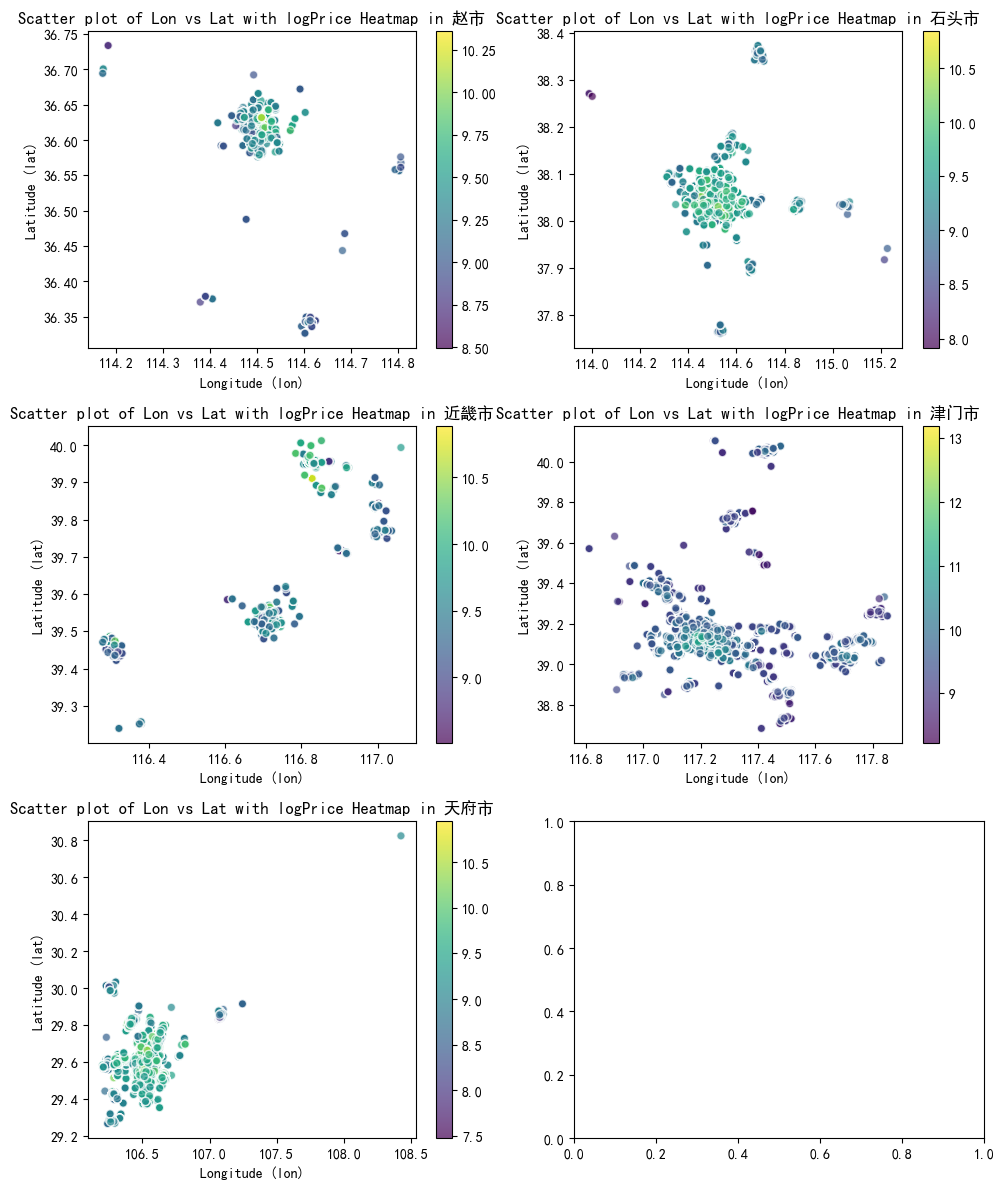

In [ ]:
city_columns = ['城市_赵市', '城市_石头市', '城市_近畿市', '城市_津门市', '城市_天府市']
nrows = 3
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))  
axs = axs.ravel()

# draw the scatter plot for each city
for ax, city_column in zip(axs, city_columns):
    data_city = train_data[train_data[city_column] == 1]
    scatter = ax.scatter(data_city['lon'], data_city['lat'], 
                         c=data_city['log平米价格'],  
                         edgecolors='w',  
                         alpha=0.7)  

    city_name = city_column.split('_')[-1]
    ax.set_title(f'Scatter plot of Lon vs Lat with logPrice Heatmap in {city_name}')
    ax.set_xlabel('Longitude (lon)')
    ax.set_ylabel('Latitude (lat)')

    plt.colorbar(scatter, ax=ax)
plt.tight_layout()
plt.show()

##### House prices tend to be higher towards the center, so I created polar variables with the center of house prices as the origin: distance and Angle to describe the polar position of each house. Furthermore, we can observe that Shitou City, Zhao City and Tianfu City are single-center cities, while Tianjin City has two centers and Kinki City has multiple ones. Therefore, they need to be calculated separately.

In [ ]:
def get_center_point(row):
    if row['城市_赵市'] == 1:
        return (114.515, 36.624)
    elif row['城市_天府市'] == 1:
        return (106.518, 29.612)
    elif row['城市_石头市'] == 1:
        return (114.536, 38.062)
    elif row['城市_津门市'] == 1:
        if row['区域_滨海新区'] == 1:
            return (117.771, 39.135)
        else:
            return (117.197, 39.128)
    elif row['城市_近畿市'] == 1:
        if (row['区域_大厂'] == 1) or (row['区域_香河'] == 1) or (row['区域_燕郊'] == 1):
            return (116.831, 39.957)
        elif row['区域_固安'] == 1:
            return (116.308, 39.477)
        else:
            return (116.714, 39.541)
    else:
        return (np.nan, np.nan)  
lon_values = train_data.apply(lambda row: get_center_point(row)[0], axis=1)
lat_values = train_data.apply(lambda row: get_center_point(row)[1], axis=1)

train_data['中心点lon'] = lon_values
train_data['中心点lat'] = lat_values

In [ ]:
test_lon_values = test_data.apply(lambda row: get_center_point(row)[0], axis=1)
test_lat_values = test_data.apply(lambda row: get_center_point(row)[1], axis=1)

test_data['中心点lon'] = test_lon_values
test_data['中心点lat'] = test_lat_values

train_data['距离'] = np.sqrt(((train_data['lon'] - train_data['中心点lon']) ** 2 + 
                                      (train_data['lat'] - train_data['中心点lat']) ** 2))
test_data['距离'] = np.sqrt(((test_data['lon'] - test_data['中心点lon']) ** 2 + 
                                      (test_data['lat'] - test_data['中心点lat']) ** 2))


In [ ]:
def calculate_angle(row):
    if row['距离'] == 0:
        return 0 
    
    angle_rad = np.arccos((row['lon'] - row['中心点lon']) / row['距离'])
    angle_deg = np.degrees(angle_rad)
    if row['lat'] < row['中心点lat']:
        angle_deg = 360 - angle_deg
    
    return angle_deg

train_data['角度'] = train_data.apply(calculate_angle, axis=1)
test_data['角度'] = test_data.apply(calculate_angle, axis=1)

In [48]:
train_data.to_csv('ML_train_data.csv', index =False)
test_data.to_csv('ML_test_data.csv', index =False)

In [3]:
train_data = pd.read_csv(r'C:\Users\Manager.Mo\Desktop\房价预测\ML_train_data.csv')
test_data = pd.read_csv(r'C:\Users\Manager.Mo\Desktop\房价预测\ML_test_data.csv')

## 3. Feature Screening
### 3.1 generate some interactions

In [4]:
train_data['建筑面积_lon'] = train_data['建筑面积']*train_data['lon']
train_data['建筑面积_lat'] = train_data['建筑面积']*train_data['lat']
train_data['建筑面积_lonlat'] = train_data['建筑面积']*train_data['lon']*train_data['lat']
train_data['distance']= np.sqrt(train_data['lon']**2 + train_data['lat']**2)
train_data['建筑面积平方']= train_data['建筑面积']**2
train_data['建筑面积_distance'] = train_data['建筑面积']*train_data['distance']
train_data['lonlat'] = train_data['lat']*train_data['lon']

test_data['建筑面积_lon'] = test_data['建筑面积']*test_data['lon']
test_data['建筑面积_lat'] = test_data['建筑面积']*test_data['lat']
test_data['建筑面积_lonlat'] = test_data['建筑面积']*test_data['lon']*test_data['lat']
test_data['distance']= np.sqrt(test_data['lon']**2 + test_data['lat']**2)
test_data['建筑面积平方']= test_data['建筑面积']**2
test_data['建筑面积_distance'] = test_data['建筑面积']*test_data['distance']
test_data['lonlat'] = test_data['lat']*test_data['lon']

In [5]:
for col in train_data.columns:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')
for col in test_data.columns:
    test_data[col] = pd.to_numeric(test_data[col], errors='coerce')
for col in train_data.columns:
    if train_data[col].dtype == bool:
        train_data[col] = train_data[col].astype(int)
for col in test_data.columns:
    if test_data[col].dtype == bool:
        test_data[col] = test_data[col].astype(int)

### 3.2 PCA - 100 Principal Components

In [12]:
y = train_data['价格']
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### 3.3 AutoEncoder

In [ ]:
y = train_data['价格']
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoder1 = Dense(160, activation="tanh")(input_layer)  
encoder2 = Dense(80, activation="relu")(encoder1) 
encoder3 = Dense(40, activation="relu")(encoder2)  
decoder1 = Dense(80, activation="relu")(encoder3)  
decoder2 = Dense(160, activation="relu")(decoder1)  
decoder3 = Dense(input_dim, activation="relu")(decoder2)

autoencoder = Model(inputs=input_layer, outputs=decoder3)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(X_train, X_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

ae_X_train = autoencoder.predict(X_train)
ae_X_test = autoencoder.predict(X_test)

Epoch 1/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 776103040.0000 - val_loss: 750207552.0000
Epoch 2/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 770800768.0000 - val_loss: 750207232.0000
Epoch 3/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 771354432.0000 - val_loss: 750206912.0000
Epoch 4/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 770959616.0000 - val_loss: 750207232.0000
Epoch 5/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 778073920.0000 - val_loss: 750207360.0000
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 3s 887us/step
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step


#### Test with different methods

In [ ]:
# PCA test
model = xgb.XGBRegressor(learning_rate = 0.025, reg_lambda = 0.04, reg_alpha = 65, gamma = 10, n_estimators = 2450, 
                         max_depth = 10, min_child_weight = 5, )


# fit the model on the training data
model.fit(X_train_pca, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test_pca)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 210010.39808278362


In [ ]:
# original data test
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# define the model
model = xgb.XGBRegressor(learning_rate = 0.025, reg_lambda = 0.04, reg_alpha = 65, gamma = 10, n_estimators = 2450, 
                         max_depth = 10, min_child_weight = 5, )


# fit the model on the training data
model.fit(X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 166839.26173698308


In [ ]:
#AutoEncoder test
model = xgb.XGBRegressor(learning_rate = 0.025, reg_lambda = 0.04, reg_alpha = 65, gamma = 10, n_estimators = 2450, 
                         max_depth = 10, min_child_weight = 5, )


# fit the model on the training data
model.fit(ae_X_train, y_train)

# make predictions for the testing data
y_pred = model.predict(ae_X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 665532.1968208733


#### the effect is: all data>PCA>AutoEncoder. Therefore, all data is selected subsequently

## 4.Models

#### 4.1 Random Forest

In [ ]:
# use GridSearch to find the best "n_estimators"
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
y = train_data['价格']  
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  

n_estimators_list = range(600,1500,100)
mae_list = []

for n_estimators in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=n_estimators)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mae_list.append(mae)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


In [ ]:
plt.figure(figsize=(12,8))
plt.plot(n_estimators_list, mae_list)
plt.xlabel('Number of Trees')
plt.ylabel('MAE')
plt.title('Random Forest Regression')
plt.grid()
plt.show()

##### found that the MAE is the smallest at 1300. Next, we optimize max_features on this basis

In [ ]:
# use GridSearch to find the best max_features
rf = RandomForestRegressor(n_estimators=1300)

# set the grid
param_grid = {'max_features': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,55,60,65,70,75,80,85,90,95,100]}

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=6)
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

y_pred = grid_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Test set MAE:', mae)

max_features_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,55,60,65,70,75,80,85,90,95,100]
mae_list = []
for max_features in max_features_list:
    rf = RandomForestRegressor(n_estimators=1300,
                                max_features=max_features)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test,y_pred)
    mae_list.append(mae)
    print("We set max_features = " + str(max_features))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(max_features_list,mae_list)
plt.xlabel('max_features')
plt.ylabel('MAE')
plt.grid()
plt.show()

#### From this, we obtained the optimal parameters of RandomForest, with MAE being 173390 on the test set

#### 4.2 XGBoost
##### XGBoost has many hyperparameters，so I used Optuna to find the best set of hyperparameters

In [14]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
y = train_data['价格']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2200, 3200),
        'max_depth': trial.suggest_int('max_depth', 8, 15),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.005,0.03),
        'subsample': trial.suggest_uniform('subsample', 0.6,1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6,1),
        'gamma': trial.suggest_uniform('gamma', 1, 10),
        'reg_alpha': trial.suggest_uniform('reg_alpha',1, 100.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight',2.0,8.0),
        'grow_policy':'lossguide'
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best score: {study.best_value:.5f}')
print(f'Best params: {study.best_params}')

[I 2024-06-03 13:35:35,881] A new study created in memory with name: no-name-bc15b7b6-be47-440c-b652-6a666446d901
[I 2024-06-03 13:37:28,409] Trial 0 finished with value: 164312.42262150167 and parameters: {'n_estimators': 2730, 'max_depth': 8, 'learning_rate': 0.02747746656834326, 'subsample': 0.7177837517358743, 'colsample_bytree': 0.9605589087104269, 'gamma': 5.193112303017308, 'reg_alpha': 13.475654013462409, 'reg_lambda': 2.9228701157638417, 'min_child_weight': 2}. Best is trial 0 with value: 164312.42262150167.
[I 2024-06-03 13:41:36,215] Trial 1 finished with value: 164559.30148902518 and parameters: {'n_estimators': 2359, 'max_depth': 13, 'learning_rate': 0.014219756286340732, 'subsample': 0.7442006568860164, 'colsample_bytree': 0.6187625314596963, 'gamma': 9.255846498083573, 'reg_alpha': 88.73157571338949, 'reg_lambda': 9.472905390422769, 'min_child_weight': 8}. Best is trial 0 with value: 164312.42262150167.
[I 2024-06-03 13:49:22,689] Trial 2 finished with value: 165715.9197

Best score: 162060.99081
Best params: {'n_estimators': 2280, 'max_depth': 11, 'learning_rate': 0.021639418762207017, 'subsample': 0.8882443740422402, 'colsample_bytree': 0.7098585176062383, 'gamma': 2.2265496878426623, 'reg_alpha': 6.977446291115538, 'reg_lambda': 3.2766462994564374, 'min_child_weight': 3}


##### In fact, I carried out this process many times and finally obtained the best parameters as follows:

In [ ]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  

xg1_model = xgb.XGBRegressor(learning_rate =   0.02865, reg_lambda =0.28023920838984356, reg_alpha = 93.26922092010518, gamma = 9.926790504999932, n_estimators = 2991, 
                         max_depth = 9, min_child_weight = 2,subsample = 0.8661393983774751, colsample_bytree =0.7088349633953773)


# fit the model on the training data
xg1_model.fit(X_train, y_train)
y_pred = xg1_model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 161688.95271362545


#### 4.3 LightGBM
##### Both LGB and XGB are essentially gradient methods with a large number of parameters. Therefore, Optuna is also chosen for parameter tuning

In [ ]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)  
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  

def objective(trial):  
    params = {  
        'boosting_type': 'gbdt',  
        'objective': 'regression',  
        'metric': 'mae',  
        'num_leaves': trial.suggest_int('num_leaves', 400, 1000),  
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.03), 
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0.9),  
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 0.9), 
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 15),  
        'verbose': -1, 
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 100.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0) 
    }  
       
    lgb_train = lgb.Dataset(X_train, y_train)  
    
    gbm = lgb.train(params,    
                 lgb_train,    
                 num_boost_round=1500,  
                 valid_sets=[lgb_train, lgb.Dataset(X_test, y_test)],  
                 valid_names=['train', 'test'],    
                 callbacks=[lgb.early_stopping(stopping_rounds=20)],  
                 )  
       
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)  
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')   
study.optimize(objective, n_trials=50)  

print(f'Best score: {study.best_value:.5f}')  
print(f'Best params: {study.best_params}')

[I 2024-06-03 19:11:04,370] A new study created in memory with name: no-name-ca6b36b9-9f96-4141-b7a1-0c6b5d1526d0


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[844]	train's l1: 80838.5	test's l1: 165470


[I 2024-06-03 19:11:58,872] Trial 0 finished with value: 165469.6113809834 and parameters: {'num_leaves': 523, 'learning_rate': 0.027923306954500196, 'feature_fraction': 0.8080334666997546, 'bagging_fraction': 0.8856928044927155, 'bagging_freq': 11, 'reg_alpha': 28.175827041490432, 'reg_lambda': 5.052000013521497}. Best is trial 0 with value: 165469.6113809834.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[876]	train's l1: 82353.9	test's l1: 165787


[I 2024-06-03 19:13:03,734] Trial 1 finished with value: 165786.84173511484 and parameters: {'num_leaves': 678, 'learning_rate': 0.022427619290932142, 'feature_fraction': 0.8052502174042163, 'bagging_fraction': 0.7685018507132382, 'bagging_freq': 7, 'reg_alpha': 2.4319002687801405, 'reg_lambda': 8.825183110561435}. Best is trial 0 with value: 165469.6113809834.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[771]	train's l1: 85494.9	test's l1: 166999


[I 2024-06-03 19:14:12,663] Trial 2 finished with value: 166999.22950796512 and parameters: {'num_leaves': 926, 'learning_rate': 0.016543002954527777, 'feature_fraction': 0.8291749626377652, 'bagging_fraction': 0.6592863616861043, 'bagging_freq': 14, 'reg_alpha': 17.081085040148526, 'reg_lambda': 0.8113785705129906}. Best is trial 0 with value: 165469.6113809834.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[549]	train's l1: 87030.6	test's l1: 166410


[I 2024-06-03 19:14:55,957] Trial 3 finished with value: 166409.78992181172 and parameters: {'num_leaves': 895, 'learning_rate': 0.029016017321241462, 'feature_fraction': 0.573700055808833, 'bagging_fraction': 0.6134630345054762, 'bagging_freq': 7, 'reg_alpha': 52.63289995797839, 'reg_lambda': 6.22569341955726}. Best is trial 0 with value: 165469.6113809834.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1264]	train's l1: 91597.2	test's l1: 166580


[I 2024-06-03 19:16:21,690] Trial 4 finished with value: 166579.50344371382 and parameters: {'num_leaves': 831, 'learning_rate': 0.011551032214898886, 'feature_fraction': 0.5323921980717335, 'bagging_fraction': 0.5219530980518952, 'bagging_freq': 8, 'reg_alpha': 87.99119350501132, 'reg_lambda': 1.857223707428386}. Best is trial 0 with value: 165469.6113809834.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[715]	train's l1: 98912.9	test's l1: 168123


[I 2024-06-03 19:17:22,872] Trial 5 finished with value: 168123.48099454193 and parameters: {'num_leaves': 649, 'learning_rate': 0.02324253284179216, 'feature_fraction': 0.7928944204979912, 'bagging_fraction': 0.5489953297334138, 'bagging_freq': 13, 'reg_alpha': 73.75523565981752, 'reg_lambda': 8.714669027734764}. Best is trial 0 with value: 165469.6113809834.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1499]	train's l1: 82523.6	test's l1: 166494


[I 2024-06-03 19:19:09,111] Trial 6 finished with value: 166494.22583776878 and parameters: {'num_leaves': 566, 'learning_rate': 0.013642545872799994, 'feature_fraction': 0.8981350267372312, 'bagging_fraction': 0.7908966416002903, 'bagging_freq': 13, 'reg_alpha': 73.70169131192516, 'reg_lambda': 3.3662605460689656}. Best is trial 0 with value: 165469.6113809834.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[676]	train's l1: 78040.6	test's l1: 166300


[I 2024-06-03 19:19:59,183] Trial 7 finished with value: 166299.78747381002 and parameters: {'num_leaves': 786, 'learning_rate': 0.026906522616271786, 'feature_fraction': 0.714696360057161, 'bagging_fraction': 0.8096933064598628, 'bagging_freq': 14, 'reg_alpha': 6.206252498295939, 'reg_lambda': 5.7780058525238776}. Best is trial 0 with value: 165469.6113809834.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1475]	train's l1: 86046.8	test's l1: 165174


[I 2024-06-03 19:22:29,323] Trial 8 finished with value: 165173.99983980317 and parameters: {'num_leaves': 873, 'learning_rate': 0.010558676900070719, 'feature_fraction': 0.8074681767141723, 'bagging_fraction': 0.6648255164393452, 'bagging_freq': 6, 'reg_alpha': 38.31919946123187, 'reg_lambda': 8.776614493708436}. Best is trial 8 with value: 165173.99983980317.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1393]	train's l1: 70510.3	test's l1: 163887


[I 2024-06-03 19:23:56,291] Trial 9 finished with value: 163886.54233801062 and parameters: {'num_leaves': 545, 'learning_rate': 0.02168855509952613, 'feature_fraction': 0.5190872898893777, 'bagging_fraction': 0.8982628743096552, 'bagging_freq': 11, 'reg_alpha': 38.80985157571134, 'reg_lambda': 4.950583639663283}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1373]	train's l1: 84394.3	test's l1: 164501


[I 2024-06-03 19:24:54,601] Trial 10 finished with value: 164501.3275679517 and parameters: {'num_leaves': 440, 'learning_rate': 0.018507789779677947, 'feature_fraction': 0.6165504830449604, 'bagging_fraction': 0.8995019016066783, 'bagging_freq': 10, 'reg_alpha': 52.53247915253109, 'reg_lambda': 3.529214592882555}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's l1: 83713.8	test's l1: 164727


[I 2024-06-03 19:25:52,999] Trial 11 finished with value: 164726.70086720848 and parameters: {'num_leaves': 409, 'learning_rate': 0.01847364586899384, 'feature_fraction': 0.6138588614035733, 'bagging_fraction': 0.885004106239931, 'bagging_freq': 10, 'reg_alpha': 52.33351127622579, 'reg_lambda': 3.2577073469834987}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1407]	train's l1: 79787.6	test's l1: 164642


[I 2024-06-03 19:26:47,915] Trial 12 finished with value: 164642.1485852473 and parameters: {'num_leaves': 405, 'learning_rate': 0.02197791329383002, 'feature_fraction': 0.647863442543585, 'bagging_fraction': 0.8512207700114861, 'bagging_freq': 10, 'reg_alpha': 38.98117817427145, 'reg_lambda': 3.5278563669612524}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1380]	train's l1: 84487.5	test's l1: 164505


[I 2024-06-03 19:27:50,663] Trial 13 finished with value: 164505.06382739224 and parameters: {'num_leaves': 542, 'learning_rate': 0.017360061392507363, 'feature_fraction': 0.5045757426681292, 'bagging_fraction': 0.7397031586208814, 'bagging_freq': 11, 'reg_alpha': 65.54195606629806, 'reg_lambda': 6.956140580524463}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[935]	train's l1: 87381.8	test's l1: 166234


[I 2024-06-03 19:28:32,993] Trial 14 finished with value: 166234.08160388758 and parameters: {'num_leaves': 462, 'learning_rate': 0.02493430515356156, 'feature_fraction': 0.6698972775428306, 'bagging_fraction': 0.8208707471962783, 'bagging_freq': 12, 'reg_alpha': 99.15449491157698, 'reg_lambda': 4.288049078172167}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1144]	train's l1: 74720.4	test's l1: 164075


[I 2024-06-03 19:29:34,146] Trial 15 finished with value: 164074.87234211186 and parameters: {'num_leaves': 604, 'learning_rate': 0.019859384207578535, 'feature_fraction': 0.5724667089601709, 'bagging_fraction': 0.8988193550649556, 'bagging_freq': 9, 'reg_alpha': 37.609935879791315, 'reg_lambda': 1.662227972681122}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[900]	train's l1: 75928.6	test's l1: 165358


[I 2024-06-03 19:30:30,285] Trial 16 finished with value: 165357.72090359966 and parameters: {'num_leaves': 748, 'learning_rate': 0.020467083257065838, 'feature_fraction': 0.5514290766719018, 'bagging_fraction': 0.7318717357153822, 'bagging_freq': 9, 'reg_alpha': 24.61542390964673, 'reg_lambda': 0.18993472410260748}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1437]	train's l1: 77239.6	test's l1: 164294


[I 2024-06-03 19:31:42,743] Trial 17 finished with value: 164293.77315447462 and parameters: {'num_leaves': 600, 'learning_rate': 0.015523504675329234, 'feature_fraction': 0.5004221685612836, 'bagging_fraction': 0.8449998508531557, 'bagging_freq': 5, 'reg_alpha': 37.01928820130974, 'reg_lambda': 1.8366529361676829}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[855]	train's l1: 79810.8	test's l1: 165563


[I 2024-06-03 19:32:36,252] Trial 18 finished with value: 165563.401612704 and parameters: {'num_leaves': 632, 'learning_rate': 0.025019523470835192, 'feature_fraction': 0.7264499334797635, 'bagging_fraction': 0.8463199274342068, 'bagging_freq': 8, 'reg_alpha': 17.36600437513829, 'reg_lambda': 7.280417161757665}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[775]	train's l1: 74797.7	test's l1: 165705


[I 2024-06-03 19:33:40,241] Trial 19 finished with value: 165704.72948365388 and parameters: {'num_leaves': 993, 'learning_rate': 0.020015877332611835, 'feature_fraction': 0.5883974905489898, 'bagging_fraction': 0.7543360932320458, 'bagging_freq': 12, 'reg_alpha': 61.75958455005977, 'reg_lambda': 2.1618437558884795}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[750]	train's l1: 84017.9	test's l1: 166071


[I 2024-06-03 19:34:27,263] Trial 20 finished with value: 166071.2580882628 and parameters: {'num_leaves': 722, 'learning_rate': 0.02470415225495424, 'feature_fraction': 0.5443866723375568, 'bagging_fraction': 0.6896054441433065, 'bagging_freq': 15, 'reg_alpha': 43.79464376025874, 'reg_lambda': 4.760622010696637}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1497]	train's l1: 76504.5	test's l1: 164490


[I 2024-06-03 19:35:41,627] Trial 21 finished with value: 164489.57943322192 and parameters: {'num_leaves': 592, 'learning_rate': 0.015258918131493887, 'feature_fraction': 0.5081319613586366, 'bagging_fraction': 0.8531355859494841, 'bagging_freq': 5, 'reg_alpha': 31.286559971697155, 'reg_lambda': 1.7846056820055634}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1499]	train's l1: 86386.9	test's l1: 164510


[I 2024-06-03 19:36:47,788] Trial 22 finished with value: 164509.97182103552 and parameters: {'num_leaves': 503, 'learning_rate': 0.013735253472279581, 'feature_fraction': 0.5020067863461757, 'bagging_fraction': 0.8995242599142854, 'bagging_freq': 5, 'reg_alpha': 43.54980663909078, 'reg_lambda': 0.9020614505868614}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1130]	train's l1: 74839.1	test's l1: 164814


[I 2024-06-03 19:37:49,819] Trial 23 finished with value: 164814.3766293801 and parameters: {'num_leaves': 614, 'learning_rate': 0.020394864488879547, 'feature_fraction': 0.5766373734169665, 'bagging_fraction': 0.8466003298198493, 'bagging_freq': 9, 'reg_alpha': 19.5972759979839, 'reg_lambda': 2.6445261109700184}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1490]	train's l1: 90444	test's l1: 164862


[I 2024-06-03 19:39:18,792] Trial 24 finished with value: 164861.58668356453 and parameters: {'num_leaves': 492, 'learning_rate': 0.015448912826553664, 'feature_fraction': 0.5311812199721994, 'bagging_fraction': 0.8073981113888323, 'bagging_freq': 6, 'reg_alpha': 32.22134177309849, 'reg_lambda': 9.852788557365098}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[965]	train's l1: 78707.6	test's l1: 164740


[I 2024-06-03 19:40:18,634] Trial 25 finished with value: 164740.41339228142 and parameters: {'num_leaves': 673, 'learning_rate': 0.01850373597499923, 'feature_fraction': 0.6138444704395858, 'bagging_fraction': 0.8691923196122819, 'bagging_freq': 9, 'reg_alpha': 60.46551503121853, 'reg_lambda': 0.04543348223417176}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's l1: 80599.6	test's l1: 164447


[I 2024-06-03 19:41:33,772] Trial 26 finished with value: 164447.04204449637 and parameters: {'num_leaves': 586, 'learning_rate': 0.013723889244122713, 'feature_fraction': 0.5573125898425855, 'bagging_fraction': 0.824507664964969, 'bagging_freq': 11, 'reg_alpha': 45.111482655328786, 'reg_lambda': 1.328031037539664}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[967]	train's l1: 83596.7	test's l1: 165499


[I 2024-06-03 19:42:25,619] Trial 27 finished with value: 165499.0250034073 and parameters: {'num_leaves': 556, 'learning_rate': 0.0214458841155328, 'feature_fraction': 0.6750849017444345, 'bagging_fraction': 0.7763072524226274, 'bagging_freq': 8, 'reg_alpha': 11.481730212329552, 'reg_lambda': 2.7071979493559337}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[973]	train's l1: 68483.4	test's l1: 164628


[I 2024-06-03 19:43:28,455] Trial 28 finished with value: 164627.65075356388 and parameters: {'num_leaves': 743, 'learning_rate': 0.023451757252742417, 'feature_fraction': 0.5987641186231034, 'bagging_fraction': 0.8681763934731802, 'bagging_freq': 6, 'reg_alpha': 33.84168118514903, 'reg_lambda': 4.258636901376613}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1436]	train's l1: 80447.8	test's l1: 164298


[I 2024-06-03 19:44:34,683] Trial 29 finished with value: 164298.32078929798 and parameters: {'num_leaves': 527, 'learning_rate': 0.017401046920571706, 'feature_fraction': 0.5280259563474504, 'bagging_fraction': 0.8828195579053193, 'bagging_freq': 11, 'reg_alpha': 25.05824499715915, 'reg_lambda': 5.304402019530185}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[817]	train's l1: 84120	test's l1: 165645


[I 2024-06-03 19:45:24,274] Trial 30 finished with value: 165645.2819504394 and parameters: {'num_leaves': 476, 'learning_rate': 0.027474861223494684, 'feature_fraction': 0.7679344609705017, 'bagging_fraction': 0.830864767283324, 'bagging_freq': 12, 'reg_alpha': 37.64944413128471, 'reg_lambda': 0.9771265365976962}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1177]	train's l1: 87983.4	test's l1: 164906


[I 2024-06-03 19:46:20,751] Trial 31 finished with value: 164905.71173271388 and parameters: {'num_leaves': 541, 'learning_rate': 0.01740680478459345, 'feature_fraction': 0.5275775975049677, 'bagging_fraction': 0.8785306508840348, 'bagging_freq': 11, 'reg_alpha': 26.571973710421197, 'reg_lambda': 5.550194550902916}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1451]	train's l1: 75958.1	test's l1: 164266


[I 2024-06-03 19:47:29,833] Trial 32 finished with value: 164266.09319084545 and parameters: {'num_leaves': 529, 'learning_rate': 0.019281602978434332, 'feature_fraction': 0.562617660545401, 'bagging_fraction': 0.8752622910201371, 'bagging_freq': 12, 'reg_alpha': 23.211150825011472, 'reg_lambda': 6.821269841227924}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1214]	train's l1: 78503.1	test's l1: 164541


[I 2024-06-03 19:48:34,678] Trial 33 finished with value: 164541.45796475685 and parameters: {'num_leaves': 613, 'learning_rate': 0.01917570895786963, 'feature_fraction': 0.5603352623722094, 'bagging_fraction': 0.8633484392272572, 'bagging_freq': 13, 'reg_alpha': 22.16758695599025, 'reg_lambda': 7.388029827496969}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[998]	train's l1: 97076.2	test's l1: 166031


[I 2024-06-03 19:49:33,028] Trial 34 finished with value: 166030.6595304106 and parameters: {'num_leaves': 693, 'learning_rate': 0.015775775826679637, 'feature_fraction': 0.633205067360199, 'bagging_fraction': 0.5988590074935676, 'bagging_freq': 12, 'reg_alpha': 8.659571974918329, 'reg_lambda': 8.139264098122338}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1215]	train's l1: 70155	test's l1: 164617


[I 2024-06-03 19:50:42,182] Trial 35 finished with value: 164617.28235770745 and parameters: {'num_leaves': 653, 'learning_rate': 0.021170020477643527, 'feature_fraction': 0.5754378327883664, 'bagging_fraction': 0.8997618162529215, 'bagging_freq': 7, 'reg_alpha': 13.42331819062491, 'reg_lambda': 6.316515642119549}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1024]	train's l1: 82078.6	test's l1: 165001


[I 2024-06-03 19:51:32,690] Trial 36 finished with value: 165001.26844383878 and parameters: {'num_leaves': 578, 'learning_rate': 0.022640263735482204, 'feature_fraction': 0.5216543894382434, 'bagging_fraction': 0.7885273935881669, 'bagging_freq': 14, 'reg_alpha': 48.44588982242276, 'reg_lambda': 6.239366968439154}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1393]	train's l1: 77990.5	test's l1: 164731


[I 2024-06-03 19:52:36,970] Trial 37 finished with value: 164730.68344383885 and parameters: {'num_leaves': 512, 'learning_rate': 0.019338818922353656, 'feature_fraction': 0.552860555351819, 'bagging_fraction': 0.8263298316662742, 'bagging_freq': 13, 'reg_alpha': 29.59376785376647, 'reg_lambda': 4.753403818619675}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1145]	train's l1: 85811.4	test's l1: 165138


[I 2024-06-03 19:53:42,628] Trial 38 finished with value: 165138.43831034598 and parameters: {'num_leaves': 612, 'learning_rate': 0.016463894281075857, 'feature_fraction': 0.5725964594405413, 'bagging_fraction': 0.7159995137920079, 'bagging_freq': 9, 'reg_alpha': 35.60703938795976, 'reg_lambda': 2.697358629110236}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[780]	train's l1: 74574.2	test's l1: 166371


[I 2024-06-03 19:54:51,760] Trial 39 finished with value: 166370.56974377434 and parameters: {'num_leaves': 660, 'learning_rate': 0.02952785648769872, 'feature_fraction': 0.8567752608944771, 'bagging_fraction': 0.8009409900583385, 'bagging_freq': 15, 'reg_alpha': 3.217595241537367, 'reg_lambda': 6.647764861992716}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's l1: 90658.3	test's l1: 164632


[I 2024-06-03 20:11:34,168] Trial 40 finished with value: 164631.78061844414 and parameters: {'num_leaves': 561, 'learning_rate': 0.012779853060533763, 'feature_fraction': 0.5934686323490891, 'bagging_fraction': 0.8389757361675488, 'bagging_freq': 7, 'reg_alpha': 57.55158840903175, 'reg_lambda': 7.9775327099094335}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's l1: 79881.8	test's l1: 164571


[I 2024-06-03 20:12:39,133] Trial 41 finished with value: 164570.65284870504 and parameters: {'num_leaves': 530, 'learning_rate': 0.016899155502966584, 'feature_fraction': 0.5206314408008842, 'bagging_fraction': 0.880544897974908, 'bagging_freq': 11, 'reg_alpha': 25.702515436232247, 'reg_lambda': 5.594044523390572}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's l1: 90256.5	test's l1: 164628


[I 2024-06-03 20:13:37,998] Trial 42 finished with value: 164627.63897109212 and parameters: {'num_leaves': 459, 'learning_rate': 0.01465639990477318, 'feature_fraction': 0.5363074577531862, 'bagging_fraction': 0.8778871481483662, 'bagging_freq': 11, 'reg_alpha': 40.82620330101153, 'reg_lambda': 4.178540244531241}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1302]	train's l1: 83409.6	test's l1: 164693


[I 2024-06-03 20:14:39,741] Trial 43 finished with value: 164692.95439026644 and parameters: {'num_leaves': 525, 'learning_rate': 0.017824748811589578, 'feature_fraction': 0.5185092249609332, 'bagging_fraction': 0.8984479274445638, 'bagging_freq': 10, 'reg_alpha': 14.585352335437669, 'reg_lambda': 5.134779632432179}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1488]	train's l1: 74110.4	test's l1: 164275


[I 2024-06-03 20:15:50,599] Trial 44 finished with value: 164274.67543932045 and parameters: {'num_leaves': 582, 'learning_rate': 0.01628847804993152, 'feature_fraction': 0.5415964413532885, 'bagging_fraction': 0.8728872063371632, 'bagging_freq': 10, 'reg_alpha': 21.044323603626545, 'reg_lambda': 1.816758404345571}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's l1: 84093.7	test's l1: 164566


[I 2024-06-03 20:17:06,742] Trial 45 finished with value: 164565.54659738843 and parameters: {'num_leaves': 638, 'learning_rate': 0.01185523940141731, 'feature_fraction': 0.5032796806755863, 'bagging_fraction': 0.8586412235786286, 'bagging_freq': 10, 'reg_alpha': 19.835101717146593, 'reg_lambda': 1.6185654919944503}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[939]	train's l1: 92367.4	test's l1: 167071


[I 2024-06-03 20:17:46,593] Trial 46 finished with value: 167071.39270705942 and parameters: {'num_leaves': 431, 'learning_rate': 0.023623019092086472, 'feature_fraction': 0.6407979084895044, 'bagging_fraction': 0.6223451235111445, 'bagging_freq': 12, 'reg_alpha': 49.1128184283141, 'reg_lambda': 0.48997689515862497}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1392]	train's l1: 76502.3	test's l1: 164729


[I 2024-06-03 20:19:00,495] Trial 47 finished with value: 164729.33793896128 and parameters: {'num_leaves': 593, 'learning_rate': 0.016241841901858803, 'feature_fraction': 0.5695567348316711, 'bagging_fraction': 0.862903469810294, 'bagging_freq': 13, 'reg_alpha': 28.677836034015083, 'reg_lambda': 2.180592466040847}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1073]	train's l1: 83867.7	test's l1: 164728


[I 2024-06-03 20:19:51,057] Trial 48 finished with value: 164727.833986767 and parameters: {'num_leaves': 483, 'learning_rate': 0.021295016829154072, 'feature_fraction': 0.6033304378736599, 'bagging_fraction': 0.8388369293451248, 'bagging_freq': 10, 'reg_alpha': 34.739013609215554, 'reg_lambda': 1.4049847799145443}. Best is trial 9 with value: 163886.54233801062.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[772]	train's l1: 97130.3	test's l1: 166967


[I 2024-06-03 20:20:35,071] Trial 49 finished with value: 166967.01082192134 and parameters: {'num_leaves': 708, 'learning_rate': 0.019408612753992034, 'feature_fraction': 0.5423251079771136, 'bagging_fraction': 0.550701347646723, 'bagging_freq': 14, 'reg_alpha': 40.189801625115365, 'reg_lambda': 3.153864993365255}. Best is trial 9 with value: 163886.54233801062.


Best score: 163886.54234
Best params: {'num_leaves': 545, 'learning_rate': 0.02168855509952613, 'feature_fraction': 0.5190872898893777, 'bagging_fraction': 0.8982628743096552, 'bagging_freq': 11, 'reg_alpha': 38.80985157571134, 'reg_lambda': 4.950583639663283}


##### The best set of hyperparameters:

In [ ]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
y = train_data['价格']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  
best_params = {
    'num_leaves': 545,
    'learning_rate': 0.02168855509952613,
    'feature_fraction': 0.5190872898893777,
    'bagging_fraction':  0.8982628743096552,
    'bagging_freq': 11,
    'reg_alpha': 38.80985157571134, 
    'reg_lambda': 4.950583639663283,
    'objective': 'regression',  
    'metric': 'mae',  
    'verbose': -1  
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

gbm1 = lgb.train(best_params,
                lgb_train,
                num_boost_round=2500,  
                valid_sets=[lgb_train, lgb_eval],
                valid_names=['train', 'test'],
                callbacks=[lgb.early_stopping(stopping_rounds=20)] 
                )

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1393]	train's l1: 70510.3	test's l1: 163887


#### 4.4 CatBoost
##### Same as XGB and LGB

In [ ]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)  
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1600, 3000),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.4 ),
        'depth': trial.suggest_int('depth', 6, 15),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'model_size_reg': trial.suggest_loguniform('model_size_reg', 1e-3, 10),         
    }
    
    train_pool = cb.Pool(data=X_train, label=y_train)
    catboost_model = cb.CatBoostRegressor(**params,  verbose=False)
    catboost_model.fit(train_pool)
    y_pred = catboost_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print(f'Best MAE: {study.best_value:.2f}')
print(f'Best params: {study.best_params}')

[I 2024-06-03 20:43:24,911] A new study created in memory with name: no-name-7ed6f8a1-9fde-44b7-88c4-ad4252744d77
[I 2024-06-03 20:59:59,812] Trial 0 finished with value: 165877.5021552125 and parameters: {'iterations': 2239, 'learning_rate': 0.08104982154164005, 'depth': 12, 'l2_leaf_reg': 0.038832046734689415, 'model_size_reg': 0.0076297899267269405}. Best is trial 0 with value: 165877.5021552125.
[I 2024-06-03 21:00:55,266] Trial 1 finished with value: 175764.87247202665 and parameters: {'iterations': 1663, 'learning_rate': 0.06992288639264624, 'depth': 7, 'l2_leaf_reg': 0.046638310041608406, 'model_size_reg': 2.1274407895584937}. Best is trial 0 with value: 165877.5021552125.
[I 2024-06-03 21:02:08,612] Trial 2 finished with value: 172576.02603448255 and parameters: {'iterations': 2763, 'learning_rate': 0.28130121297518346, 'depth': 6, 'l2_leaf_reg': 0.10199112931862049, 'model_size_reg': 0.24326159603668335}. Best is trial 0 with value: 165877.5021552125.
[I 2024-06-03 21:09:40,47

#### 4.5 Neural Network
##### 4.5.1 Ordinary ANN

In [ ]:
# standardize the data
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
test_combined_reindexed = test_data.reindex(columns=X.columns, fill_value=0)

scaler = StandardScaler()
combined_data = pd.concat([X, test_combined_reindexed])
combined_data_standardized = scaler.fit_transform(combined_data)
combined_data_standardized_df = pd.DataFrame(combined_data_standardized, columns=combined_data.columns)
train_size = len(X)
train_data_standardized = combined_data_standardized_df[:train_size]
test_data_standardized = combined_data_standardized_df[train_size:]


In [ ]:
X = train_data_standardized
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
ANN_model = models.Sequential()
# Add the first hidden layer, which has 320 neurons, using the relu activation function
ANN_model.add(layers.Dense(320, activation='relu', input_shape=(X_train.shape[1],)))

# Add more hidden layers
ANN_model.add(layers.Dense(160, activation='relu'))
ANN_model.add(layers.Dense(80, activation='tanh'))
ANN_model.add(layers.Dense(40, activation='relu'))
ANN_model.add(layers.Dense(20, activation='relu'))

ANN_model.add(layers.Dense(1))
ANN_model.compile(optimizer='adam', loss='mae', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history=ANN_model.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/200
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1811727.8750 - mae: 1811727.8750 - val_loss: 1721515.0000 - val_mae: 1721346.8750
Epoch 2/200
811/811 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1674508.8750 - mae: 1674510.0000 - val_loss: 1323416.1250 - val_mae: 1323242.1250
Epoch 3/200
811/811 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1195264.8750 - mae: 1195266.0000 - val_loss: 842732.3750 - val_mae: 842482.8750
Epoch 4/200
811/811 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 784489.0625 - mae: 784487.5000 - val_loss: 531368.9375 - val_mae: 531117.0625
Epoch 5/200
811/811 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 512731.6875 - mae: 512731.7812 - val_loss: 412597.7812 - val_mae: 412312.1250
Epoch 6/200
811/811 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 409057.9375 - mae: 409058.5312 - val_loss: 353555.2812 - val_mae: 353242.2812
Epoch 7/200
811/811 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 358674.6250 - mae: 358675.1562 - val_loss: 318337.1875 - val_mae: 318050.4062
Epoch 8/200
811/8

#### 4.5.2 Wide&Deep Neural Network（inspired by Heng-Tze Cheng's 2016 paper）

In [ ]:
X = train_data_standardized
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
ANN_wide_model = models.Sequential()
ANN_wide_model.add(layers.Dense(320, activation='relu', input_shape=(X_train.shape[1],)))

ANN_wide_model.add(layers.Dense(160, activation='relu'))
ANN_wide_model.add(layers.Dense(80, activation='tanh'))
ANN_wide_model.add(layers.Dense(40, activation='relu'))

residual = layers.Input(shape=(X_train.shape[1],))  
ANN_model = Add()([ANN_model, residual]) 
ANN_model.add(layers.Dense(20, activation='relu'))
ANN_model.add(layers.Dense(1))
ANN_model.compile(optimizer='adam', loss='mae', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = ANN_model.fit(X_train, y_train, epochs=200, batch_size=128, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping],
                        initial_epoch=0)  

#### 4.6 Model Blending

In [13]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)  
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
xg1_y_pred = xg1_model.predict(X_test)
gbm1_y_pred = gbm1.predict(X_test)
weighted_y_pred = 0.5*xg1_y_pred + 0.5*gbm1_y_pred
mae = mean_absolute_error(y_test, weighted_y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 160763.54957103287


##### Model Blending was more effective than the baseline model.

#### 4.7 Model Stacking

In [14]:
xg1_pred = xg1_model.predict(X)
gbm1_pred = gbm1.predict(X)
xg1_pred_df = pd.DataFrame(xg1_pred, columns=['xg1_pred'])
gbm1_pred_df = pd.DataFrame(gbm1_pred, columns=['gbm1_pred'])
X = pd.concat([X, xg1_pred_df, gbm1_pred_df], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  


# define the model
stack_xg_model = xgb.XGBRegressor(learning_rate =   0.02865, reg_lambda =0.28023920838984356, reg_alpha = 93.26922092010518, gamma = 9.926790504999932, n_estimators = 2991, 
                         max_depth = 9, min_child_weight = 2,subsample = 0.8661393983774751, colsample_bytree =0.7088349633953773)


# fit the model on the training data
stack_xg_model.fit(X_train, y_train)
y_pred = stack_xg_model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 165798.04755851463


#### 4.8 Idea: Draw on the White test learned in econometrics to further fit the residuals

In [ ]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  

xg1_pred = xg1_model.predict(X)
u_hat = y-xg1_pred

In [34]:
xg1_pred_sq = xg1_pred**2
ln_xg1_pred = np.log(xg1_pred)
sin_xg1_pred = np.sin(xg1_pred)
cos_xg1_pred = np.cos(xg1_pred)
xg1_pred = pd.DataFrame(xg1_pred, columns=['xg1_pred'])
xg1_pred_sq = pd.DataFrame(xg1_pred_sq, columns=['xg1_pred_sq'])
ln_xg1_pred = pd.DataFrame(ln_xg1_pred, columns=['ln_xg1_pred'])
sin_xg1_pred = pd.DataFrame(sin_xg1_pred, columns=['sin_xg1_pred'])
cos_xg1_pred = pd.DataFrame(cos_xg1_pred, columns=['cos_xg1_pred'])
X = pd.concat([X, xg1_pred, xg1_pred_sq,ln_xg1_pred,sin_xg1_pred,cos_xg1_pred], axis=1)

In [ ]:
X = X[['xg1_pred','xg1_pred_sq','ln_xg1_pred','sin_xg1_pred','cos_xg1_pred']]
y = u_hat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  
linear_model = LinearRegression()  
lasso_model = Lasso()  
ridge_model = Ridge()  
elasticnet_model = ElasticNet()  

linear_model.fit(X_train, y_train)  
lasso_model.fit(X_train, y_train)  
ridge_model.fit(X_train, y_train)  
elasticnet_model.fit(X_train, y_train)  

linear_pred = linear_model.predict(X_test)  
lasso_pred = lasso_model.predict(X_test)  
ridge_pred = ridge_model.predict(X_test)  
elasticnet_pred = elasticnet_model.predict(X_test)  

In [ ]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
y = train_data['价格']  
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  
xg1_pred = xg1_model.predict(X_test)
y_test_withredidual = xg1_pred + linear_pred
linear_mae = mean_absolute_error(y_test, y_test_withredidual)  
print("Linear Regression MAE:", linear_mae)  

Linear Regression MAE: 161697.211425122


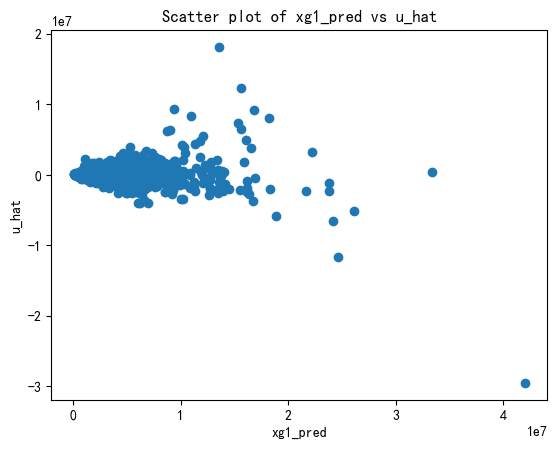

In [ ]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
y = train_data['价格']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)  

xg1_pred = xg1_model.predict(X_test)
u_hat = y_test-xg1_pred
plt.scatter(xg1_pred, u_hat)

plt.title('Scatter plot of xg1_pred vs u_hat')
plt.xlabel('xg1_pred')
plt.ylabel('u_hat')
plt.show()

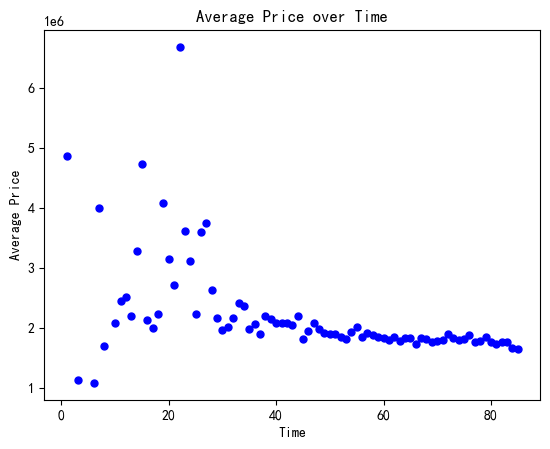

In [ ]:
time_grouped = train_data.groupby('时间')['价格'].mean().reset_index()

plt.plot(time_grouped['时间'], time_grouped['价格'], 'o', markersize=5, color='blue')

plt.title('Average Price over Time')
plt.xlabel('Time')
plt.ylabel('Average Price')

plt.show()

### 5.Innovation
#### 5.1: Use AutoGluon to conduct automated ml (https://arxiv.org/abs/2003.06505)

In [40]:
X = train_data.drop(['平米价格','log平米价格'], axis=1)
y = train_data['价格']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
feature_metadata = FeatureMetadata.from_df(X_train)
print(feature_metadata)

('float', []) :  43 | ['建筑面积', '配备电梯', 'lon', 'lat', '房屋总数', ...]
('int', [])   : 184 | ['价格', '年份', '停车位', '房屋户型_NA', '所在楼层_NA', ...]


In [41]:
hyperparameters = get_hyperparameter_config('multimodal')
predictor = TabularPredictor(label=label).fit(
    train_data=X_train,
    hyperparameters=hyperparameters,
    feature_metadata=feature_metadata,
)

No path specified. Models will be saved in: "AutogluonModels\ag-20240604_044048"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240604_044048"
=================== System

[1000]	valid_set's rmse: 441364
[2000]	valid_set's rmse: 415628
[3000]	valid_set's rmse: 404534
[4000]	valid_set's rmse: 398980
[5000]	valid_set's rmse: 394826
[6000]	valid_set's rmse: 392584
[7000]	valid_set's rmse: 390763
[8000]	valid_set's rmse: 388274
[9000]	valid_set's rmse: 387299
[10000]	valid_set's rmse: 386722


	-386687.8022	 = Validation score   (-root_mean_squared_error)
	61.32s	 = Training   runtime
	0.57s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 481125
[2000]	valid_set's rmse: 423736
[3000]	valid_set's rmse: 398753
[4000]	valid_set's rmse: 387398
[5000]	valid_set's rmse: 380135
[6000]	valid_set's rmse: 373840
[7000]	valid_set's rmse: 369799
[8000]	valid_set's rmse: 365395
[9000]	valid_set's rmse: 362231
[10000]	valid_set's rmse: 360696


	-360695.7918	 = Validation score   (-root_mean_squared_error)
	61.0s	 = Training   runtime
	0.49s	 = Validation runtime
Fitting model: CatBoost ...
	-369565.4536	 = Validation score   (-root_mean_squared_error)
	335.56s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-425303.4469	 = Validation score   (-root_mean_squared_error)
	26.96s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-532813.2585	 = Validation score   (-root_mean_squared_error)
	323.16s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: VowpalWabbit ...
		`import vowpalwabbit` failed.
A quick tip is to install via `pip install vowpalwabbit>=9,<9.10
Fitting model: LightGBMLarge ...


[1000]	valid_set's rmse: 392377
[2000]	valid_set's rmse: 386783
[3000]	valid_set's rmse: 386497


	-386228.4584	 = Validation score   (-root_mean_squared_error)
	47.9s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: MultiModalPredictor ...
		The total system num_gpus=0 is less than minimum num_gpus=1 to fit MultiModalPredictorModel. Consider using a machine with more GPUs.
Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\Manager.Mo\anaconda3\Lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1904, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, total_resources=total_resources, **model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Manager.Mo\anaconda3\Lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1844, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, total_resources=total_resources, **model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [42]:
predictor.leaderboard(X_test,extra_metrics=['mean_absolute_error','median_absolute_error'],silent=True)

,model,score_test,mean_absolute_error,median_absolute_error,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-384448.655802,-165726.258577,-98646.375,-349499.476946,root_mean_squared_error,9.545044,0.770544,767.640071,0.014005,0.000000,0.015627,2,True,7
1,CatBoost,-394208.383922,-167471.858996,-97608.250,-369565.453552,root_mean_squared_error,0.125431,0.015622,335.561285,0.125431,0.015622,335.561285,1,True,3
2,XGBoost,-395519.311909,-171186.838540,-98811.500,-425303.446860,root_mean_squared_error,0.591291,0.078173,26.960813,0.591291,0.078173,26.960813,1,True,4
3,LightGBM,-396489.554563,-165374.571170,-93215.375,-386687.802157,root_mean_squared_error,6.016023,0.566705,61.317749,6.016023,0.566705,61.317749,1,True,1
4,LightGBMXT,-403255.200412,-169315.389086,-96236.500,-360695.791788,root_mean_squared_error,6.247408,0.492435,61.003521,6.247408,0.492435,61.003521,1,True,2
5,LightGBMLarge,-415911.627047,-165765.570893,-92301.500,-386228.458389,root_mean_squared_error,2.765517,0.208096,47.901576,2.765517,0.208096,47.901576,1,True,6
6,NeuralNetTorch,-525442.809957,-390631.599147,-354830.125,-532813.258495,root_mean_squared_error,0.392684,0.054391,323.158062,0.392684,0.054391,323.158062,1,True,5


#### 5.2 Use OpenFE to generate Deep Features (https://arxiv.org/abs/2211.12507)

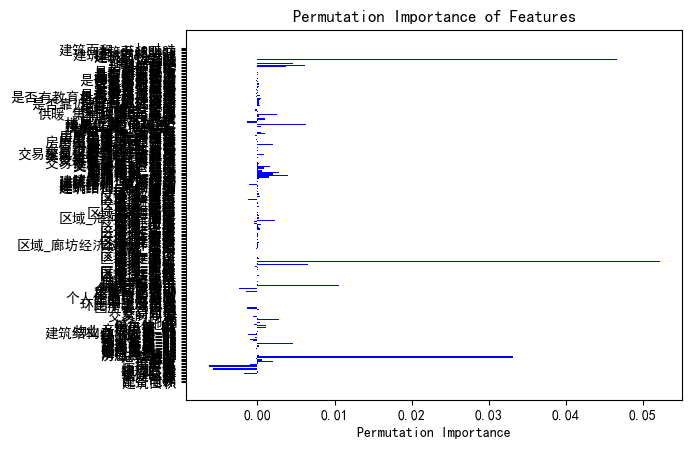

In [ ]:
result = permutation_importance(xg1_model, X_test, y_test, n_repeats=10, random_state=111)

# draw the feature importance
importances = result.importances_mean

feature_names = X_train.columns

plt.barh(range(len(importances)), importances, color='blue', ecolor='black', capsize=3)
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

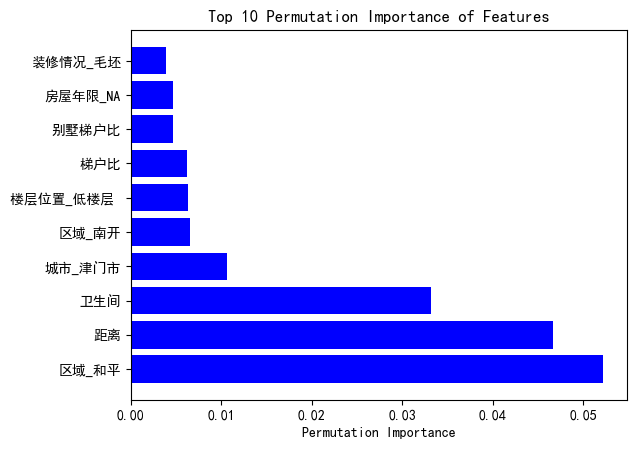

In [ ]:
top_feature_idxs = np.argsort(importances)[::-1][:10]

# select the top 10 features
top_importances = importances[top_feature_idxs]
top_feature_names = [feature_names[i] for i in top_feature_idxs]

plt.barh(range(len(top_importances)), top_importances, color='blue', ecolor='black', capsize=3)
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Permutation Importance')
plt.title('Top 10 Permutation Importance of Features')
plt.show()

In [ ]:
X = train_data.drop(['价格','平米价格','log平米价格'], axis=1)
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'n_estimators': 2991, 'max_depth': 9, 'learning_rate': 0.02865,
    'subsample': 0.8661393983774751, 'colsample_bytree':  0.7088349633953773,
    'gamma': 9.926790504999932, 'reg_alpha': 93.26922092010518, 
    'reg_lambda': 0.28023920838984356, 'min_child_weight': 2
}

model = xgb.train(params=params, dtrain=dtrain)

# Output the top 100 variables in terms of feature importance
print(sorted(model.get_score(importance_type='weight').items(), key=lambda x: x[1], reverse=True)[:100])

[('lon', 272.0), ('物 业 费', 222.0), ('距离', 205.0), ('lonlat', 183.0), ('建筑面积', 172.0), ('建筑面积_lat', 143.0), ('房屋总数', 126.0), ('lat', 115.0), ('容 积 率', 104.0), ('角度', 104.0), ('卧室', 100.0), ('建筑面积_distance', 93.0), ('停车位', 91.0), ('指数户梯比', 86.0), ('总楼层数', 79.0), ('建筑面积_lon', 77.0), ('楼栋总数', 66.0), ('建筑面积_lonlat', 63.0), ('distance', 60.0), ('绿 化 率', 54.0), ('交易时间差', 54.0), ('卫生间', 48.0), ('户', 44.0), ('停车费用', 40.0), ('燃气费', 39.0), ('梯户比', 34.0), ('区域_南开', 31.0), ('梯', 27.0), ('预期上涨占比', 27.0), ('供热费', 25.0), ('区域_和平', 24.0), ('建筑面积平方', 24.0), ('地铁', 22.0), ('区域_河西', 22.0), ('净上涨积分', 20.0), ('房贷环比变动', 20.0), ('客厅', 19.0), ('时间', 18.0), ('个人住房贷款', 18.0), ('北', 17.0), ('楼层位置_高楼层 ', 17.0), ('物业办公电话_NA', 16.0), ('交易月份', 16.0), ('环比下降城市数', 15.0), ('区域_长寿', 15.0), ('供暖_集中供暖', 15.0), ('建筑面积_NA', 13.0), ('南', 13.0), ('装修情况_毛坯', 13.0), ('配备电梯', 12.0), ('西', 11.0), ('区域_开发区', 10.0), ('区域_津南', 10.0), ('是否有医疗设施', 10.0), ('物业公司_NA', 9.0), ('国房景气指数', 9.0), ('企业景气指数', 9.0), ('个人住房贷款利率', 9.0), ('装修情况_精装',

In [24]:
important_fs = [('lon', 272.0), ('物 业 费', 222.0), ('距离', 205.0), ('lonlat', 183.0), ('建筑面积', 172.0), ('建筑面积_lat', 143.0), ('房屋总数', 126.0), ('lat', 115.0), ('容 积 率', 104.0), ('角度', 104.0), ('卧室', 100.0), ('建筑面积_distance', 93.0), ('停车位', 91.0), ('指数户梯比', 86.0), ('总楼层数', 79.0), ('建筑面积_lon', 77.0), ('楼栋总数', 66.0), ('建筑面积_lonlat', 63.0), ('distance', 60.0), ('绿 化 率', 54.0), ('交易时间差', 54.0), ('卫生间', 48.0), ('户', 44.0), ('停车费用', 40.0), ('燃气费', 39.0), ('梯户比', 34.0), ('区域_南开', 31.0), ('梯', 27.0), ('预期上涨占比', 27.0), ('供热费', 25.0), ('区域_和平', 24.0), ('建筑面积平方', 24.0), ('地铁', 22.0), ('区域_河西', 22.0), ('净上涨积分', 20.0), ('房贷环比变动', 20.0), ('客厅', 19.0), ('时间', 18.0), ('个人住房贷款', 18.0), ('北', 17.0), ('楼层位置_高楼层 ', 17.0), ('物业办公电话_NA', 16.0), ('交易月份', 16.0), ('环比下降城市数', 15.0), ('区域_长寿', 15.0), ('供暖_集中供暖', 15.0), ('建筑面积_NA', 13.0), ('南', 13.0), ('装修情况_毛坯', 13.0), ('配备电梯', 12.0), ('西', 11.0), ('区域_开发区', 10.0), ('区域_津南', 10.0), ('是否有医疗设施', 10.0), ('物业公司_NA', 9.0), ('国房景气指数', 9.0), ('企业景气指数', 9.0), ('个人住房贷款利率', 9.0), ('装修情况_精装', 9.0), ('供水_商水/民水', 9.0), ('年份', 8.0), ('开发商_NA', 8.0), ('东', 7.0), ('区域_渝北', 7.0), ('区域_燕郊', 7.0), ('供电_商电/民电', 7.0), ('供电_民电', 7.0), ('是否靠近公交站', 7.0), ('房屋年限_满两年', 6.0), ('楼层位置_中楼层 ', 6.0), ('供暖_集中供暖/自采暖', 6.0), ('是否有娱乐休闲', 6.0), ('别墅梯户比', 6.0), ('梯户比例_NA', 5.0), ('交易年份', 5.0), ('个贷同比变动', 5.0), ('个贷环比变动', 5.0), ('区域_河北', 5.0), ('区域_西青', 5.0), ('建筑结构_砖混结构', 5.0), ('楼层位置_低楼层 ', 5.0), ('厨房', 4.0), ('配备电梯_NA', 4.0), ('供热费_NA', 4.0), ('房地产贷款', 4.0), ('城市_津门市', 4.0), ('区域_固安', 4.0), ('区域_河东', 4.0), ('区域_渝中', 4.0), ('建筑结构_未知结构', 4.0), ('建筑结构_混合结构', 4.0), ('装修情况_其他', 4.0), ('交易权属_商品房', 4.0), ('房屋用途_别墅', 4.0), ('产权所属_共有', 4.0), ('供水_民水', 4.0), ('物业类别_NA', 3.0), ('燃气费_NA', 3.0), ('建筑结构_钢混结构', 3.0), ('别墅类型_独栋', 3.0)]
important_fs = [i[0] for i in important_fs]
print(important_fs)

['lon', '物 业 费', '距离', 'lonlat', '建筑面积', '建筑面积_lat', '房屋总数', 'lat', '容 积 率', '角度', '卧室', '建筑面积_distance', '停车位', '指数户梯比', '总楼层数', '建筑面积_lon', '楼栋总数', '建筑面积_lonlat', 'distance', '绿 化 率', '交易时间差', '卫生间', '户', '停车费用', '燃气费', '梯户比', '区域_南开', '梯', '预期上涨占比', '供热费', '区域_和平', '建筑面积平方', '地铁', '区域_河西', '净上涨积分', '房贷环比变动', '客厅', '时间', '个人住房贷款', '北', '楼层位置_高楼层 ', '物业办公电话_NA', '交易月份', '环比下降城市数', '区域_长寿', '供暖_集中供暖', '建筑面积_NA', '南', '装修情况_毛坯', '配备电梯', '西', '区域_开发区', '区域_津南', '是否有医疗设施', '物业公司_NA', '国房景气指数', '企业景气指数', '个人住房贷款利率', '装修情况_精装', '供水_商水/民水', '年份', '开发商_NA', '东', '区域_渝北', '区域_燕郊', '供电_商电/民电', '供电_民电', '是否靠近公交站', '房屋年限_满两年', '楼层位置_中楼层 ', '供暖_集中供暖/自采暖', '是否有娱乐休闲', '别墅梯户比', '梯户比例_NA', '交易年份', '个贷同比变动', '个贷环比变动', '区域_河北', '区域_西青', '建筑结构_砖混结构', '楼层位置_低楼层 ', '厨房', '配备电梯_NA', '供热费_NA', '房地产贷款', '城市_津门市', '区域_固安', '区域_河东', '区域_渝中', '建筑结构_未知结构', '建筑结构_混合结构', '装修情况_其他', '交易权属_商品房', '房屋用途_别墅', '产权所属_共有', '供水_民水', '物业类别_NA', '燃气费_NA', '建筑结构_钢混结构', '别墅类型_独栋']


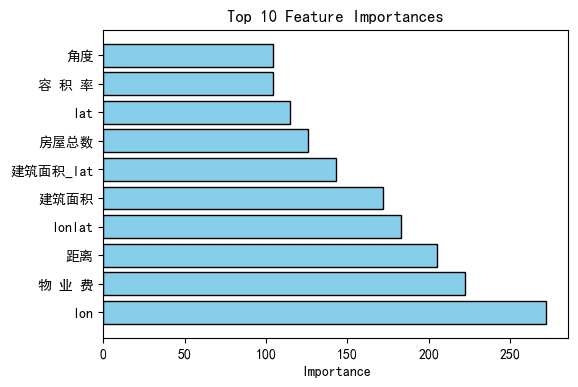

In [ ]:
data = [('lon', 272.0), ('物 业 费', 222.0), ('距离', 205.0), ('lonlat', 183.0),
        ('建筑面积', 172.0), ('建筑面积_lat', 143.0), ('房屋总数', 126.0),
        ('lat', 115.0), ('容 积 率', 104.0), ('角度', 104.0)]

sorted_data = sorted(data, key=lambda x: x[1], reverse=True)

features, importances = zip(*sorted_data[:10])

plt.figure(figsize=(6, 4))  
plt.barh(range(len(importances)), importances, color='skyblue', edgecolor='black')
plt.yticks(range(len(importances)), features)
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')

plt.show()

In [26]:
X = train_data[important_fs]
y = train_data['价格']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
ofe = OpenFE()
ofe.fit(data=X_train, label = y_train, n_jobs =4)
X_train,X_test = transform(X_train,X_test,features,n_jobs =4)

The number of candidate features is 88922
Start stage I selection.


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [43:15<00:00, 162.23s/it]


52090 same features have been deleted.


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [09:34<00:00, 35.94s/it]


The number of remaining candidate features is 4604
Start stage II selection.


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [03:14<00:00, 12.16s/it]


Finish data processing.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.082383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862244
[LightGBM] [Info] Number of data points in the train set: 82951, number of used features: 4704
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


NameError: name 'features' is not defined

In [27]:
X_train, X_test = transform(X_train, X_test, ofe.new_features_list[:50], n_jobs=4) # transform the train and test data according to generated features.

In [29]:
# define the model
ofe_xg1_model = xgb.XGBRegressor(learning_rate =   0.02865, reg_lambda =0.28023920838984356, reg_alpha = 93.26922092010518, gamma = 9.926790504999932, n_estimators = 2991, 
                         max_depth = 9, min_child_weight = 2,subsample = 0.8661393983774751, colsample_bytree =0.7088349633953773)


# fit the model on the training data
ofe_xg1_model.fit(X_train, y_train)
y_pred = ofe_xg1_model.predict(X_test)

# calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 158042.7501060834


##### It can be seen that after using OpenFE to filter features, the effect has been significantly improved